# Fit and compare hue tuning curves

Our goal is to compare hue tuning properties of a give neuron across artificial and natural conditions. 

- For artificial condition, we simply fit a non-paramteric tuning curve as a density estimate of the spike count as a function of hue angle. We treat this as the **artificial tuning curve**. See **Section A**.

For natural conditions, it is difficult to estimate the presented hue from the fixated patch due to well-known issues of color constancy and color contrast. To this end, we take two different approaches. 

- First, we build a model based on the circular hue-histogram of the patch (along with nuisance variables). To this model, we present artificial hue patches encoded as a one-hot-vector corresponding to the histogram of a flat hue map, and treat the model prediction as the **natural tuning curve**. See **Section B**.


- Second, we build a model based on transfer learning from a pre-trained neural network (**VGG16**). We train separate Poisson gradient boosted regression models for four different pre-trained neural network codebooks: the last convolutional layer (**L5**), the two fully-connected layers (**L6**, **L7**) and the softmax layer (**L8**). We then present artificial hue patches (inputs encoded as RGB pixels) and compute the model predictions. We refer to these as the **synthetic tuning curve**. See **Section B**.

We then compare these tuning curves using a circular version of earth-mover's distance. See **Section C**.

## Imports

In [1]:
# compute
import numpy as np
import pandas as pd
import keras

# data io
import glob
import deepdish as dd
import sys
sys.path.append('../')

# image
import cv2

# plot
import matplotlib.pyplot as plt
%matplotlib inline

# spykes
from spykes.neuropop import NeuroPop
from spykes.neurovis import NeuroVis

# stats
from scipy.stats import circmean

# machine learning
import xgboost as xgb

# local
import V4pyutils as V4

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 2: GeForce GTX TITAN X (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5103)
/opt/anaconda/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load merged sessions

### Filenames

In [2]:
h5path = '../V4pydata/H5data/M3/'
data = pd.read_excel('/home/klab/Projects/02-V4py/V4py/V4pydata/natural_artificial.xlsx')
data_M3 = data[data['Animal']=='M3']
data_M3.head()

Animal                         Natural                           Hue  \
7      M3  Ro150125_s83a_FreeViewPic_0004  Ro150126_s83a_huecircle_0003   
8      M3  Ro150125_s83a_FreeViewPic_0005  Ro150126_s83a_huecircle_0003   
9      M3  Ro150127_s84a_FreeViewPic_0001  Ro150127_s84a_huecircle_0003   
10     M3  Ro150128_s85a_FreeViewPic_0001  Ro150128_s85a_huecircle_0003   
11     M3  Ro150129_s86a_FreeViewPic_0001  Ro150129_s86a_huecircle_0003   

                                  Ori                            RF  
7   Ro150126_s83a_v4fv_orituning_0002  Ro150126_s83a_rfMapping_0001  
8   Ro150126_s83a_v4fv_orituning_0002  Ro150126_s83a_rfMapping_0001  
9   Ro150127_s84a_v4fv_orituning_0002  Ro150127_s84a_rfMapping_0001  
10  Ro150128_s85a_v4fv_orituning_0002  Ro150128_s85a_rfMapping_0001  
11  Ro150129_s86a_v4fv_orituning_0002  Ro150129_s86a_rfMapping_0001

### All sessions

In [3]:
df = pd.read_pickle('../02-preprocessed_data/M3/merged_art_data_across_sessions')
df.head()

predictors.onset_times  predictors.offset_times  predictors.col  \
0                1.376900                 1.565233           370.0   
1                1.694233                 1.893600           370.0   
2                2.004167                 2.184233           378.0   
3                3.884300                 4.081467           370.0   
4                4.194367                 4.393767           370.0   

   predictors.row  predictors.hue  predictors.hue_prev  predictors.stim_dur  \
0           370.0        1.822645          -999.000000             0.188333   
1           370.0       -1.336950             1.822645             0.199367   
2           378.0       -2.928811            -1.336950             0.180067   
3           370.0       -2.863301            -2.928811             0.197167   
4           370.0       -0.836567            -2.863301             0.199400   

   predictors.off_to_onset_times  spikes.0101  spikes.0201       ...        \
0                    -999.000000          NaN          NaN       ...         
1                       0.129000          NaN          NaN       ...         
2                       0.110567          NaN          NaN       ...         
3                       1.700067          NaN          NaN       ...         
4                       0.112900          NaN          NaN       ...         

   spikes.9002  spikes.9100  spikes.9102  spikes.9200  spikes.9202  \
0          NaN          0.0          NaN          0.0          NaN   
1          NaN          1.0          NaN          1.0          NaN   
2          NaN          0.0          NaN          0.0          NaN   
3          NaN          0.0          NaN          0.0          NaN   
4          NaN          2.0          NaN          2.0          NaN   

   spikes.9300  spikes.9400  spikes.9600  \
0          NaN          NaN          0.0   
1          NaN          NaN          2.0   
2          NaN          NaN          3.0   
3          NaN          NaN          6.0   
4          NaN          NaN          1.0   

                                        session.name  session.number  
0  ../V4pydata/H5data/M3/Ro150126_s83a_huecircle_...               0  
1  ../V4pydata/H5data/M3/Ro150126_s83a_huecircle_...               0  
2  ../V4pydata/H5data/M3/Ro150126_s83a_huecircle_...               0  
3  ../V4pydata/H5data/M3/Ro150126_s83a_huecircle_...               0  
4  ../V4pydata/H5data/M3/Ro150126_s83a_huecircle_...               0  

[5 rows x 117 columns]

### Merging table

In [4]:
df_neurons = pd.read_pickle('../02-preprocessed_data/M3/data_to_combine_across_sessions')
df_neurons.head(10)

name        art_sessions  \
0  spikes.0101              [2, 3]   
1  spikes.0301              [8, 9]   
2  spikes.0500           [3, 4, 5]   
3  spikes.0500           [4, 5, 6]   
4  spikes.0600        [2, 3, 4, 5]   
5  spikes.0700        [0, 1, 2, 3]   
6  spikes.0700              [4, 5]   
7  spikes.0700              [7, 8]   
8  spikes.0900  [0, 1, 2, 3, 4, 5]   
9  spikes.0900     [3, 4, 5, 6, 7]   

                                       art_filenames     nat_sessions  \
0  [Ro150127_s84a_huecircle_0003, Ro150128_s85a_h...              [4]   
1  [Ro150211_s88a_huecircle_0003, Ro150212_289a_h...         [11, 12]   
2  [Ro150128_s85a_huecircle_0003, Ro150129_s86a_h...           [5, 6]   
3  [Ro150129_s86a_huecircle_0003, Ro150129_s86a_h...        [6, 7, 8]   
4  [Ro150127_s84a_huecircle_0003, Ro150128_s85a_h...        [4, 5, 6]   
5  [Ro150126_s83a_huecircle_0003, Ro150126_s83a_h...        [2, 3, 4]   
6  [Ro150129_s86a_huecircle_0003, Ro150129_s86a_h...              [6]   
7  [Ro150211_s88a_huecircle_0003, Ro150211_s88a_h...             [10]   
8  [Ro150126_s83a_huecircle_0003, Ro150126_s83a_h...  [2, 3, 4, 5, 6]   
9  [Ro150128_s85a_huecircle_0003, Ro150129_s86a_h...  [5, 6, 7, 8, 9]   

                                       nat_filenames  
0                   [Ro150129_s86a_FreeViewPic_0001]  
1  [Ro150216_s91a_FreeViewPic_0004, Ro150216_s91a...  
2  [Ro150129_s86a_FreeViewPic_0005, Ro150210_s87a...  
3  [Ro150210_s87a_FreeViewPic_manyimage_0004, Ro1...  
4  [Ro150129_s86a_FreeViewPic_0001, Ro150129_s86a...  
5  [Ro150127_s84a_FreeViewPic_0001, Ro150128_s85a...  
6         [Ro150210_s87a_FreeViewPic_manyimage_0004]  
7                   [Ro150213_s90a_FreeViewPic_0004]  
8  [Ro150127_s84a_FreeViewPic_0001, Ro150128_s85a...  
9  [Ro150129_s86a_FreeViewPic_0005, Ro150210_s87a...

## A. Artificial tuning curves

### Fit models for each neuron

spikes.0101
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.203104405728
...runnning cv-fold 2 of 2
pseudo_R2:  0.0757558137031
pseudo_R2_cv: 0.139430 (+/- 0.045025)
------------------------------------------------------------



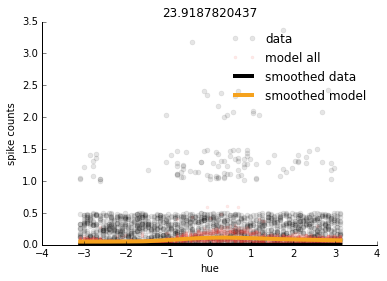

spikes.0301
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.687377793089
...runnning cv-fold 2 of 2
pseudo_R2:  0.101933213735
pseudo_R2_cv: 0.394656 (+/- 0.206986)
------------------------------------------------------------



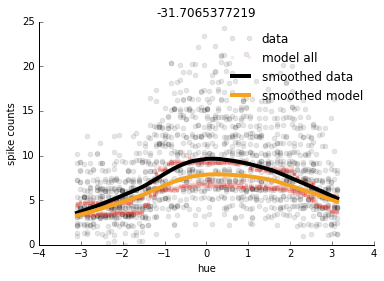

spikes.0500
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -0.436355444104
...runnning cv-fold 2 of 3
pseudo_R2:  -0.284999428996
...runnning cv-fold 3 of 3
pseudo_R2:  0.00188086694473
pseudo_R2_cv: -0.239825 (+/- 0.104927)
------------------------------------------------------------



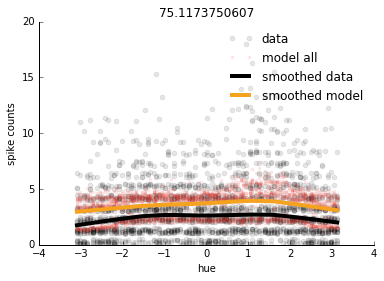

spikes.0500
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -0.122742425057
...runnning cv-fold 2 of 3
pseudo_R2:  0.209414417139
...runnning cv-fold 3 of 3
pseudo_R2:  0.338744560215
pseudo_R2_cv: 0.141806 (+/- 0.112221)
------------------------------------------------------------



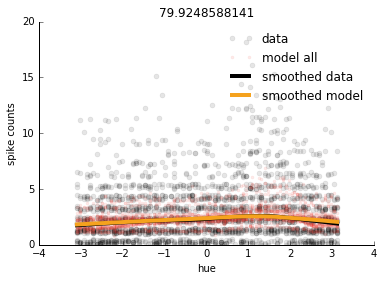

spikes.0600
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 4
pseudo_R2:  -0.242452582303
...runnning cv-fold 2 of 4
pseudo_R2:  -0.163974877458
...runnning cv-fold 3 of 4
pseudo_R2:  0.247786150359
...runnning cv-fold 4 of 4
pseudo_R2:  -0.295710296046
pseudo_R2_cv: -0.113588 (+/- 0.106918)
------------------------------------------------------------



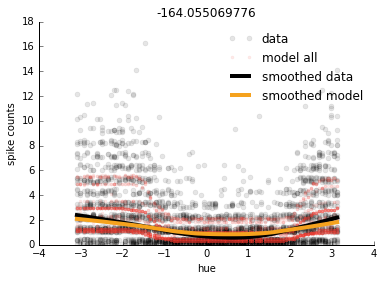

spikes.0700
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 4
pseudo_R2:  0.31442951267
...runnning cv-fold 2 of 4
pseudo_R2:  0.379128757243
...runnning cv-fold 3 of 4
pseudo_R2:  0.11929209515
...runnning cv-fold 4 of 4
pseudo_R2:  0.214002826117
pseudo_R2_cv: 0.256713 (+/- 0.049387)
------------------------------------------------------------



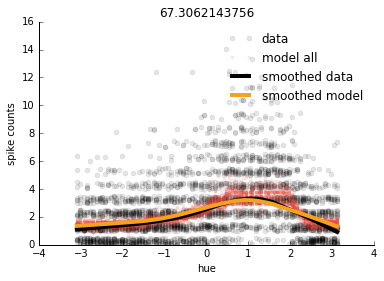

spikes.0700
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0983122264378
...runnning cv-fold 2 of 2
pseudo_R2:  0.00635340519715
pseudo_R2_cv: 0.052333 (+/- 0.032512)
------------------------------------------------------------



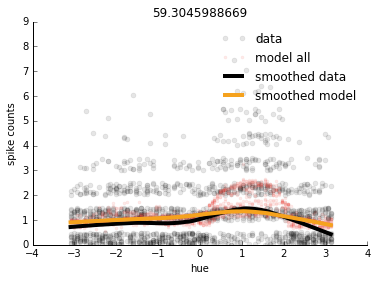

spikes.0700
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0431744975479
...runnning cv-fold 2 of 2
pseudo_R2:  0.163981458711
pseudo_R2_cv: 0.103578 (+/- 0.042712)
------------------------------------------------------------



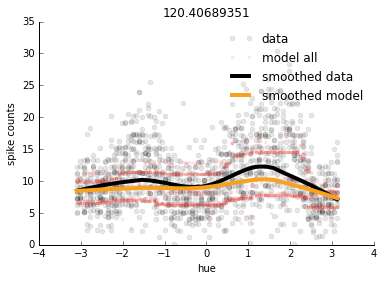

spikes.0900
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 6
pseudo_R2:  0.359327553671
...runnning cv-fold 2 of 6
pseudo_R2:  0.29566236479
...runnning cv-fold 3 of 6
pseudo_R2:  0.266655997466
...runnning cv-fold 4 of 6
pseudo_R2:  0.0371209488044
...runnning cv-fold 5 of 6
pseudo_R2:  0.145171107482
...runnning cv-fold 6 of 6
pseudo_R2:  0.275990959542
pseudo_R2_cv: 0.229988 (+/- 0.043746)
------------------------------------------------------------



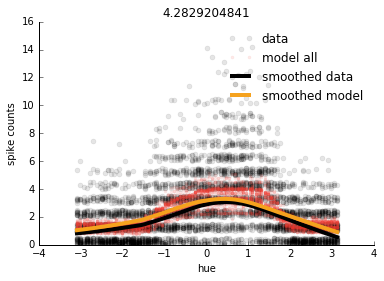

spikes.0900
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 5
pseudo_R2:  0.137906719267
...runnning cv-fold 2 of 5
pseudo_R2:  -0.783306547192
...runnning cv-fold 3 of 5
pseudo_R2:  0.320921399453
...runnning cv-fold 4 of 5
pseudo_R2:  0.174126657672
...runnning cv-fold 5 of 5
pseudo_R2:  0.521118389727
pseudo_R2_cv: 0.074153 (+/- 0.200994)
------------------------------------------------------------



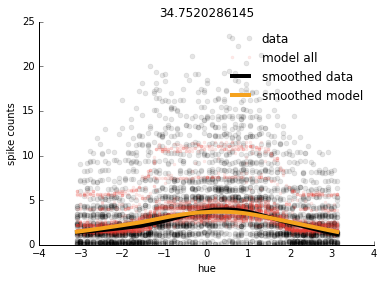

spikes.0900
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -0.108667176106
...runnning cv-fold 2 of 3
pseudo_R2:  0.328655446433
...runnning cv-fold 3 of 3
pseudo_R2:  -0.401030161063
pseudo_R2_cv: -0.060347 (+/- 0.173116)
------------------------------------------------------------



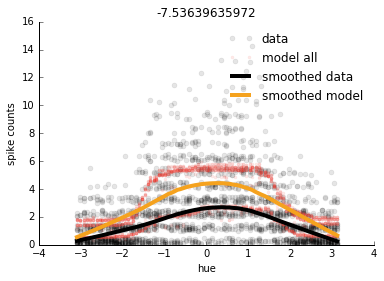

spikes.1100
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0849455141901
...runnning cv-fold 2 of 2
pseudo_R2:  0.0340035838605
pseudo_R2_cv: 0.059475 (+/- 0.018011)
------------------------------------------------------------



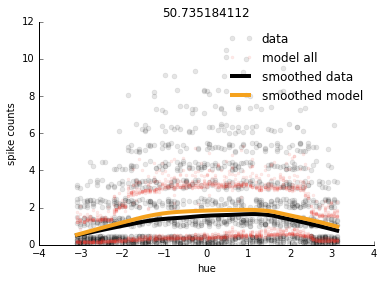

spikes.1400
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.00961962842399
...runnning cv-fold 2 of 2
pseudo_R2:  0.0481842886671
pseudo_R2_cv: 0.028902 (+/- 0.013635)
------------------------------------------------------------



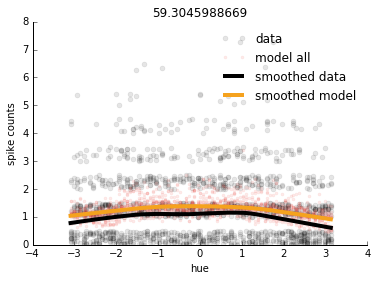

spikes.1400
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0137995801078
...runnning cv-fold 2 of 2
pseudo_R2:  0.0158159121509
pseudo_R2_cv: 0.014808 (+/- 0.000713)
------------------------------------------------------------



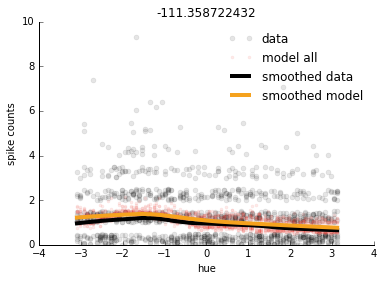

spikes.1400
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  0.0580979346671
...runnning cv-fold 2 of 3
pseudo_R2:  0.0775278289208
...runnning cv-fold 3 of 3
pseudo_R2:  0.159385015325
pseudo_R2_cv: 0.098337 (+/- 0.025340)
------------------------------------------------------------



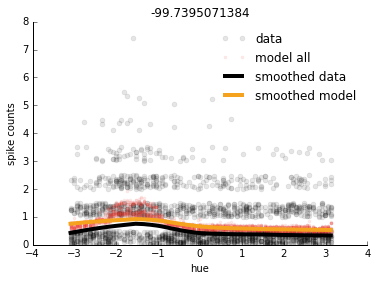

spikes.1500
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  0.0697173417525
...runnning cv-fold 2 of 3
pseudo_R2:  0.0986115474178
...runnning cv-fold 3 of 3
pseudo_R2:  0.133484713461
pseudo_R2_cv: 0.100605 (+/- 0.015052)
------------------------------------------------------------



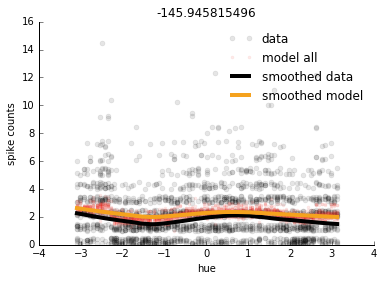

spikes.1500
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0560644662896
...runnning cv-fold 2 of 2
pseudo_R2:  0.00675146925561
pseudo_R2_cv: 0.031408 (+/- 0.017435)
------------------------------------------------------------



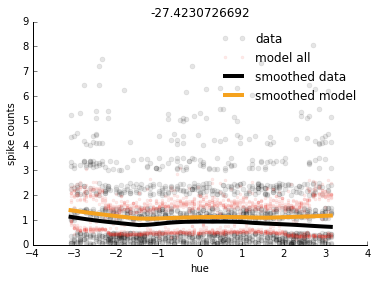

spikes.1701
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0516396644575
...runnning cv-fold 2 of 2
pseudo_R2:  0.0736473265405
pseudo_R2_cv: 0.062643 (+/- 0.007781)
------------------------------------------------------------



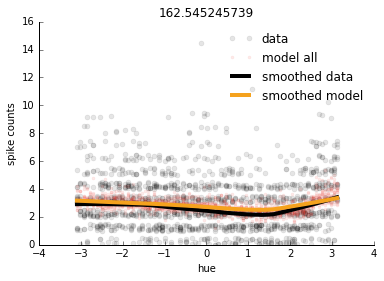

spikes.2101
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.153728427287
...runnning cv-fold 2 of 2
pseudo_R2:  0.24627134402
pseudo_R2_cv: 0.200000 (+/- 0.032719)
------------------------------------------------------------



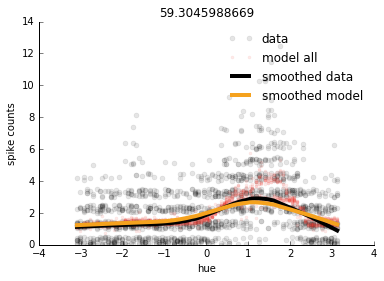

spikes.2501
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.101649797304
...runnning cv-fold 2 of 2
pseudo_R2:  0.0413798833483
pseudo_R2_cv: 0.071515 (+/- 0.021309)
------------------------------------------------------------



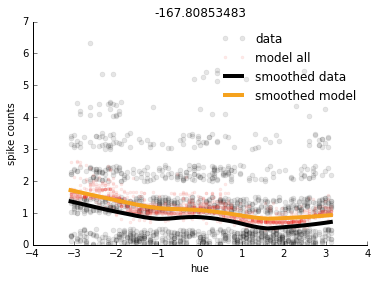

spikes.2801
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.401825264175
...runnning cv-fold 2 of 2
pseudo_R2:  0.0604444763773
pseudo_R2_cv: 0.231135 (+/- 0.120696)
------------------------------------------------------------



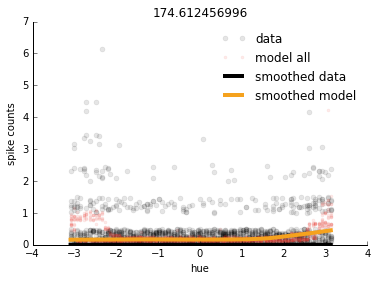

spikes.2901
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0766470117489
...runnning cv-fold 2 of 2
pseudo_R2:  0.0782667691515
pseudo_R2_cv: 0.077457 (+/- 0.000573)
------------------------------------------------------------



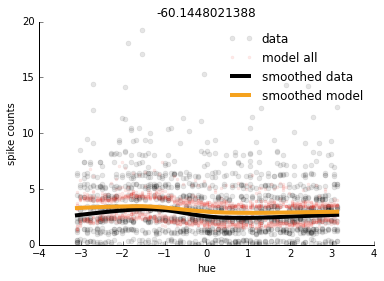

spikes.2901
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0223180718849
...runnning cv-fold 2 of 2
pseudo_R2:  0.0413233532723
pseudo_R2_cv: 0.031821 (+/- 0.006719)
------------------------------------------------------------



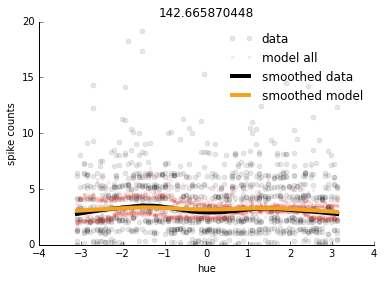

spikes.3201
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0742972012712
...runnning cv-fold 2 of 2
pseudo_R2:  0.120542021467
pseudo_R2_cv: 0.097420 (+/- 0.016350)
------------------------------------------------------------



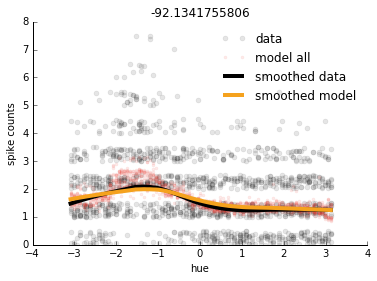

spikes.3201
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.447630612364
...runnning cv-fold 2 of 2
pseudo_R2:  0.0237642370868
pseudo_R2_cv: 0.235697 (+/- 0.149859)
------------------------------------------------------------



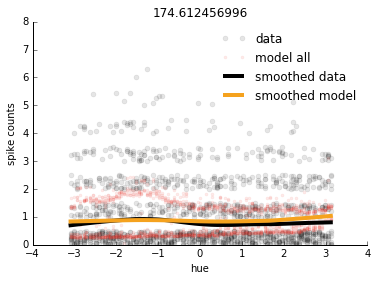

spikes.3401
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.00654180796344
...runnning cv-fold 2 of 2
pseudo_R2:  0.00259220851007
pseudo_R2_cv: 0.004567 (+/- 0.001396)
------------------------------------------------------------



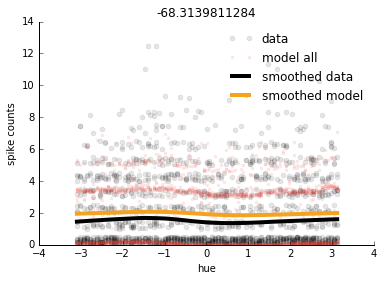

spikes.3401
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.000343479422393
...runnning cv-fold 2 of 2
pseudo_R2:  0.091958058912
pseudo_R2_cv: 0.046151 (+/- 0.032391)
------------------------------------------------------------



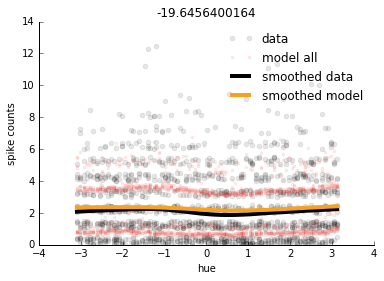

spikes.3601
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.027035793882
...runnning cv-fold 2 of 2
pseudo_R2:  0.0399506672636
pseudo_R2_cv: 0.033493 (+/- 0.004566)
------------------------------------------------------------



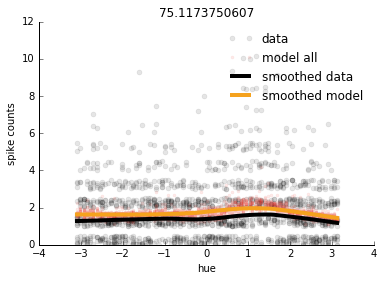

spikes.3701
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.105040974369
...runnning cv-fold 2 of 2
pseudo_R2:  0.039548619369
pseudo_R2_cv: 0.072295 (+/- 0.023155)
------------------------------------------------------------



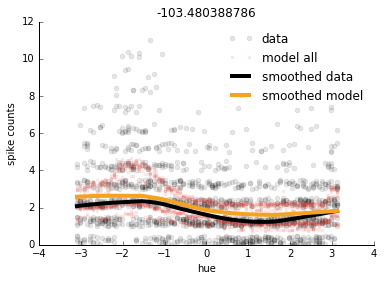

spikes.3701
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 4
pseudo_R2:  0.432350792077
...runnning cv-fold 2 of 4
pseudo_R2:  -0.661120491225
...runnning cv-fold 3 of 4
pseudo_R2:  -0.0469670440827
...runnning cv-fold 4 of 4
pseudo_R2:  0.374699744532
pseudo_R2_cv: 0.024741 (+/- 0.218541)
------------------------------------------------------------



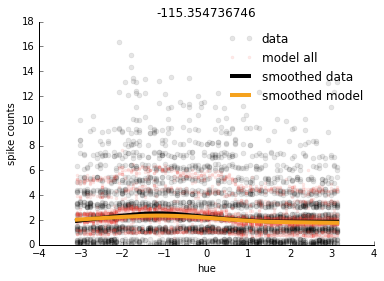

spikes.3701
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  0.503140327727
...runnning cv-fold 2 of 3
pseudo_R2:  0.186599663317
...runnning cv-fold 3 of 3
pseudo_R2:  0.375270428665
pseudo_R2_cv: 0.355003 (+/- 0.075067)
------------------------------------------------------------



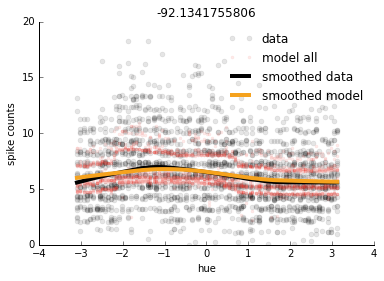

spikes.3801
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.02534579571
...runnning cv-fold 2 of 2
pseudo_R2:  0.0937606213538
pseudo_R2_cv: 0.059553 (+/- 0.024188)
------------------------------------------------------------



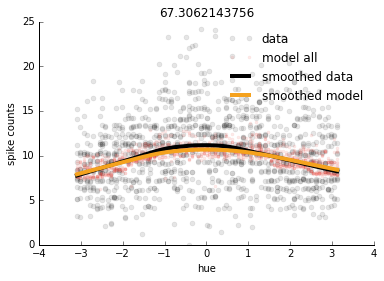

spikes.3801
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0244924949914
...runnning cv-fold 2 of 2
pseudo_R2:  0.128205652851
pseudo_R2_cv: 0.076349 (+/- 0.036668)
------------------------------------------------------------



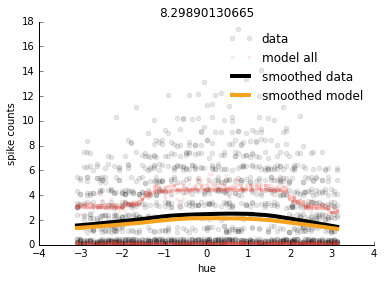

spikes.3901
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.039476206431
...runnning cv-fold 2 of 2
pseudo_R2:  0.00292986667398
pseudo_R2_cv: 0.021203 (+/- 0.012921)
------------------------------------------------------------



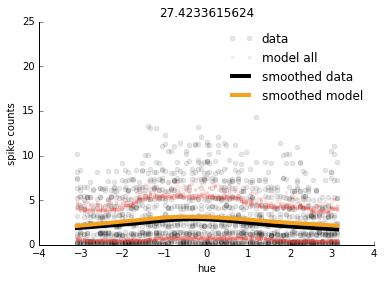

spikes.3901
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.194120287027
...runnning cv-fold 2 of 2
pseudo_R2:  0.0534903909729
pseudo_R2_cv: 0.123805 (+/- 0.049720)
------------------------------------------------------------



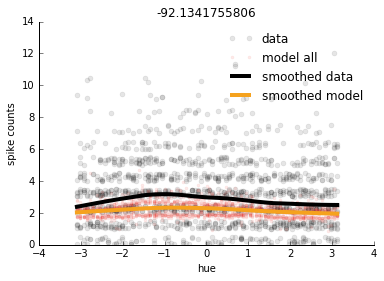

spikes.4301
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0451714584635
...runnning cv-fold 2 of 2
pseudo_R2:  0.0597813852843
pseudo_R2_cv: 0.052476 (+/- 0.005165)
------------------------------------------------------------



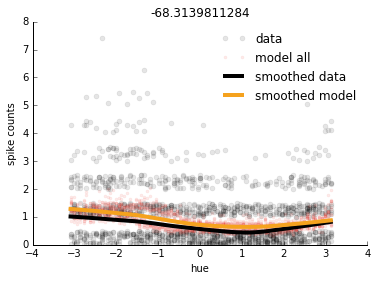

spikes.4301
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0298323141512
...runnning cv-fold 2 of 2
pseudo_R2:  0.00839101540961
pseudo_R2_cv: 0.019112 (+/- 0.007581)
------------------------------------------------------------



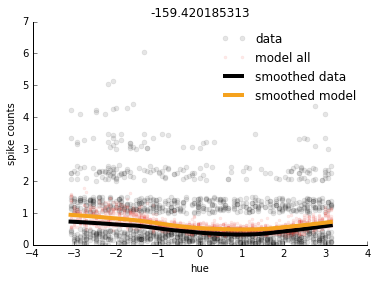

spikes.4401
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 4
pseudo_R2:  -0.422221338063
...runnning cv-fold 2 of 4
pseudo_R2:  0.368155784892
...runnning cv-fold 3 of 4
pseudo_R2:  0.301848928298
...runnning cv-fold 4 of 4
pseudo_R2:  -0.699372153594
pseudo_R2_cv: -0.112897 (+/- 0.229546)
------------------------------------------------------------



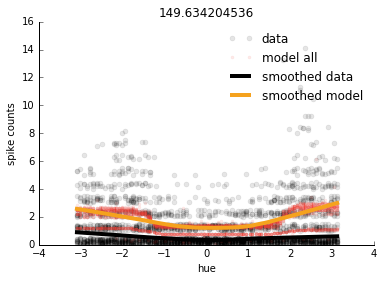

spikes.4501
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0315122381826
...runnning cv-fold 2 of 2
pseudo_R2:  0.0498956774487
pseudo_R2_cv: 0.040704 (+/- 0.006500)
------------------------------------------------------------



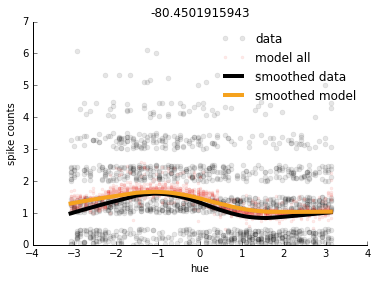

spikes.4501
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 4
pseudo_R2:  0.0455681451124
...runnning cv-fold 2 of 4
pseudo_R2:  0.0652930434912
...runnning cv-fold 3 of 4
pseudo_R2:  0.0867399251917
...runnning cv-fold 4 of 4
pseudo_R2:  0.0832488636619
pseudo_R2_cv: 0.070212 (+/- 0.008195)
------------------------------------------------------------



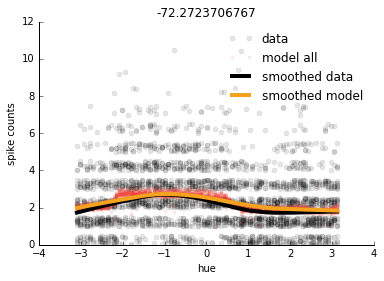

spikes.4501
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.104742661954
...runnning cv-fold 2 of 2
pseudo_R2:  0.0437970041827
pseudo_R2_cv: 0.074270 (+/- 0.021548)
------------------------------------------------------------



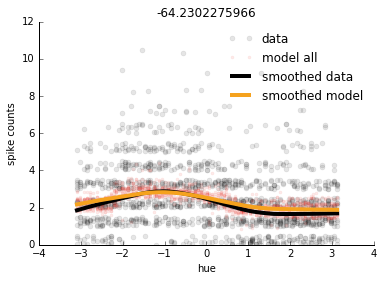

spikes.4501
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.14480423223
...runnning cv-fold 2 of 2
pseudo_R2:  0.0882391788309
pseudo_R2_cv: 0.116522 (+/- 0.019999)
------------------------------------------------------------



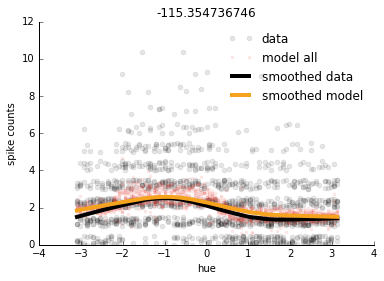

spikes.4701
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  0.105354483327
...runnning cv-fold 2 of 3
pseudo_R2:  0.109366003081
...runnning cv-fold 3 of 3
pseudo_R2:  0.116985667597
pseudo_R2_cv: 0.110569 (+/- 0.002785)
------------------------------------------------------------



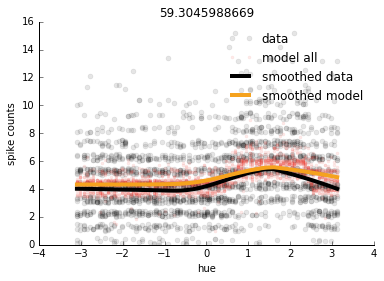

spikes.4701
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.00356566155512
...runnning cv-fold 2 of 2
pseudo_R2:  0.174434143081
pseudo_R2_cv: 0.089000 (+/- 0.060411)
------------------------------------------------------------



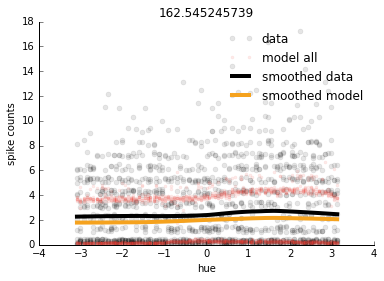

spikes.4901
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.196812952002
...runnning cv-fold 2 of 2
pseudo_R2:  0.137267721054
pseudo_R2_cv: 0.167040 (+/- 0.021052)
------------------------------------------------------------



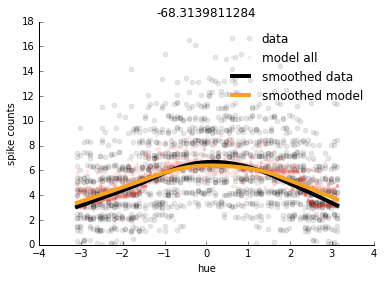

spikes.4901
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0588226477289
...runnning cv-fold 2 of 2
pseudo_R2:  0.0361993529565
pseudo_R2_cv: 0.047511 (+/- 0.007999)
------------------------------------------------------------



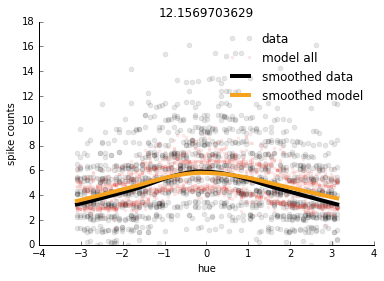

spikes.5101
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  0.0438283293749
...runnning cv-fold 2 of 3
pseudo_R2:  0.0523006149115
...runnning cv-fold 3 of 3
pseudo_R2:  0.0717654397394
pseudo_R2_cv: 0.055965 (+/- 0.006753)
------------------------------------------------------------



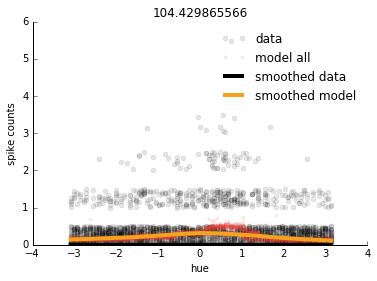

spikes.5101
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.134428833383
...runnning cv-fold 2 of 2
pseudo_R2:  0.219049247928
pseudo_R2_cv: 0.176739 (+/- 0.029918)
------------------------------------------------------------



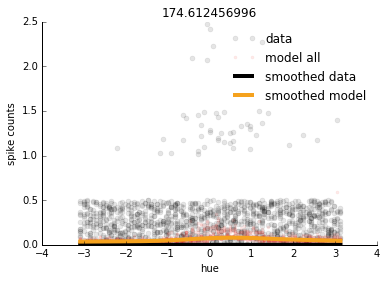

spikes.5201
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  0.148181754164
...runnning cv-fold 2 of 3
pseudo_R2:  -0.0977028384341
...runnning cv-fold 3 of 3
pseudo_R2:  -0.336690120777
pseudo_R2_cv: -0.095404 (+/- 0.114289)
------------------------------------------------------------



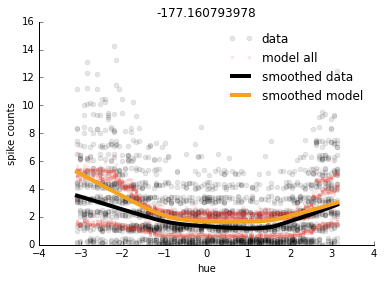

spikes.5201
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0317424784309
...runnning cv-fold 2 of 2
pseudo_R2:  0.0181431774441
pseudo_R2_cv: 0.024943 (+/- 0.004808)
------------------------------------------------------------



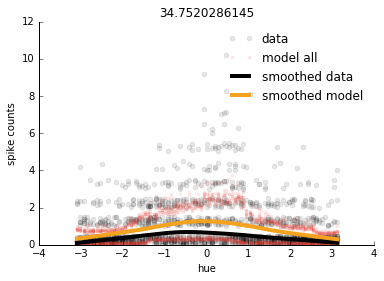

spikes.5201
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.24811065656
...runnning cv-fold 2 of 2
pseudo_R2:  0.205361005087
pseudo_R2_cv: 0.226736 (+/- 0.015114)
------------------------------------------------------------



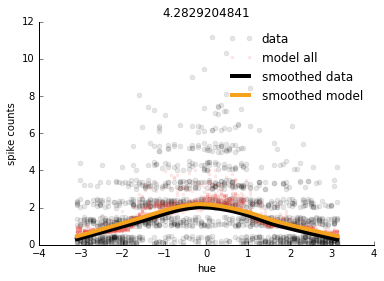

spikes.5201
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.013255474834
...runnning cv-fold 2 of 2
pseudo_R2:  0.00240276834356
pseudo_R2_cv: 0.007829 (+/- 0.003837)
------------------------------------------------------------



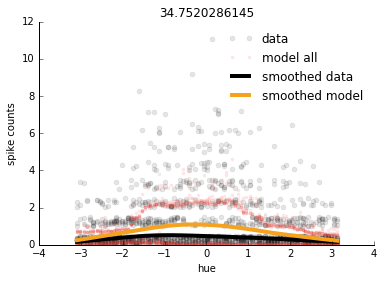

spikes.5301
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 5
pseudo_R2:  0.352850134306
...runnning cv-fold 2 of 5
pseudo_R2:  0.46460283485
...runnning cv-fold 3 of 5
pseudo_R2:  0.0271561543848
...runnning cv-fold 4 of 5
pseudo_R2:  0.298577846677
...runnning cv-fold 5 of 5
pseudo_R2:  0.153536883855
pseudo_R2_cv: 0.259345 (+/- 0.068562)
------------------------------------------------------------



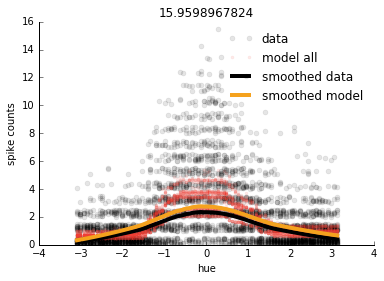

spikes.5301
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0115579387155
...runnning cv-fold 2 of 2
pseudo_R2:  0.0331106110964
pseudo_R2_cv: 0.022334 (+/- 0.007620)
------------------------------------------------------------



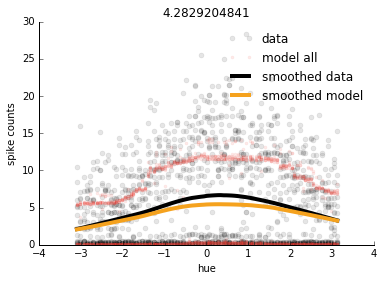

spikes.5401
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0442991968853
...runnning cv-fold 2 of 2
pseudo_R2:  0.0156147143568
pseudo_R2_cv: 0.029957 (+/- 0.010141)
------------------------------------------------------------



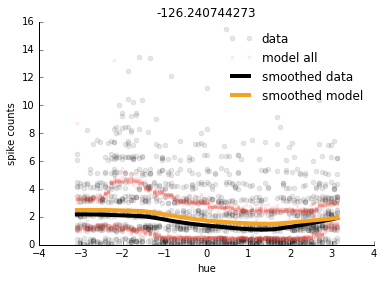

spikes.5401
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 4
pseudo_R2:  0.412726293776
...runnning cv-fold 2 of 4
pseudo_R2:  0.256978283047
...runnning cv-fold 3 of 4
pseudo_R2:  0.142662390831
...runnning cv-fold 4 of 4
pseudo_R2:  0.0327988260934
pseudo_R2_cv: 0.211291 (+/- 0.070371)
------------------------------------------------------------



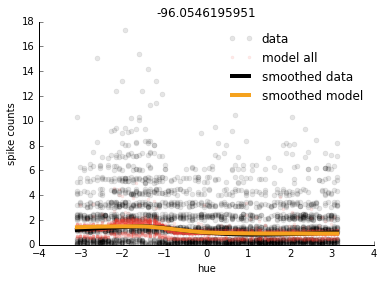

spikes.5401
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.000752487994575
...runnning cv-fold 2 of 2
pseudo_R2:  0.0205534728426
pseudo_R2_cv: 0.010653 (+/- 0.007001)
------------------------------------------------------------



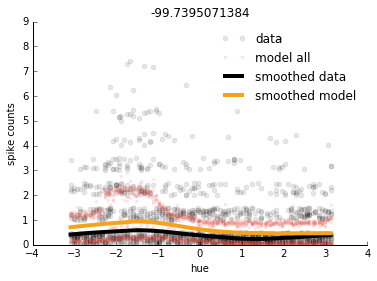

spikes.5501
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.191831410068
...runnning cv-fold 2 of 2
pseudo_R2:  0.215111758804
pseudo_R2_cv: 0.203472 (+/- 0.008231)
------------------------------------------------------------



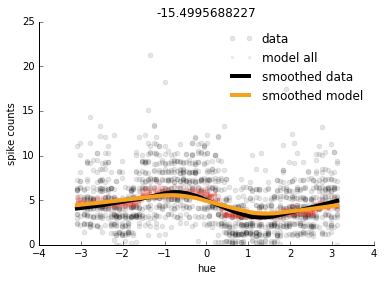

spikes.5501
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0453114991535
...runnning cv-fold 2 of 2
pseudo_R2:  0.0606258878346
pseudo_R2_cv: 0.052969 (+/- 0.005414)
------------------------------------------------------------



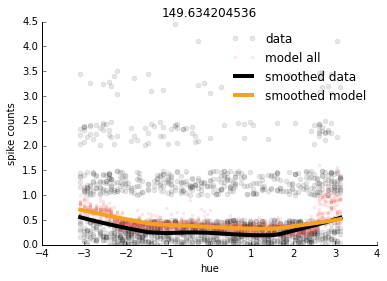

spikes.5601
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0275189334335
...runnning cv-fold 2 of 2
pseudo_R2:  0.0272489368045
pseudo_R2_cv: 0.027384 (+/- 0.000095)
------------------------------------------------------------



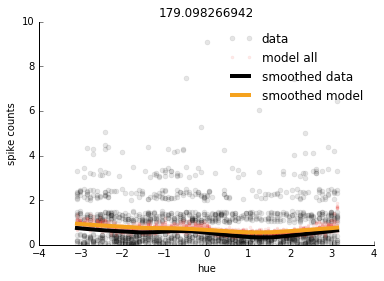

spikes.5601
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0571190563682
...runnning cv-fold 2 of 2
pseudo_R2:  0.127808566163
pseudo_R2_cv: 0.092464 (+/- 0.024993)
------------------------------------------------------------



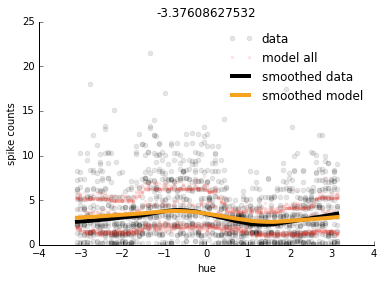

spikes.5601
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0437487716561
...runnning cv-fold 2 of 2
pseudo_R2:  0.0627842122088
pseudo_R2_cv: 0.053266 (+/- 0.006730)
------------------------------------------------------------



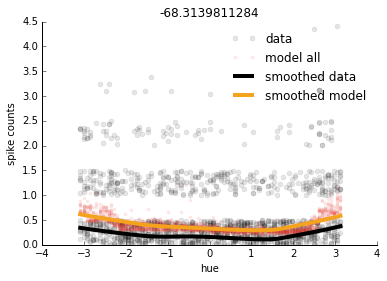

spikes.5801
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 4
pseudo_R2:  0.237651292196
...runnning cv-fold 2 of 4
pseudo_R2:  0.0811726728435
...runnning cv-fold 3 of 4
pseudo_R2:  0.517494569942
...runnning cv-fold 4 of 4
pseudo_R2:  0.349279646598
pseudo_R2_cv: 0.296400 (+/- 0.079629)
------------------------------------------------------------



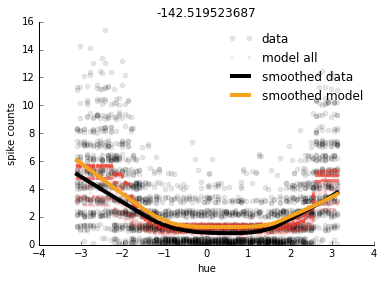

spikes.5801
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 5
pseudo_R2:  0.186208203924
...runnning cv-fold 2 of 5
pseudo_R2:  0.557513660345
...runnning cv-fold 3 of 5
pseudo_R2:  0.404329056363
...runnning cv-fold 4 of 5
pseudo_R2:  0.579092078592
...runnning cv-fold 5 of 5
pseudo_R2:  0.487487075862
pseudo_R2_cv: 0.442926 (+/- 0.063577)
------------------------------------------------------------



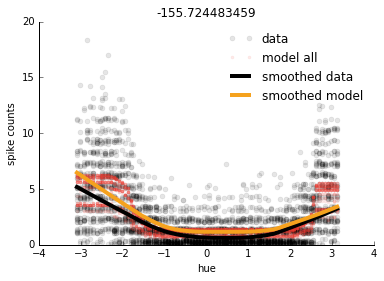

spikes.6101
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0764914480142
...runnning cv-fold 2 of 2
pseudo_R2:  0.0443983209744
pseudo_R2_cv: 0.060445 (+/- 0.011347)
------------------------------------------------------------



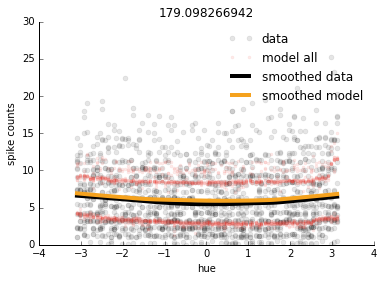

spikes.6201
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.160886984578
...runnning cv-fold 2 of 2
pseudo_R2:  0.0673341632292
pseudo_R2_cv: 0.114111 (+/- 0.033076)
------------------------------------------------------------



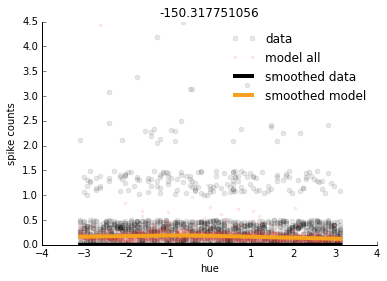

spikes.6400
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0720192967897
...runnning cv-fold 2 of 2
pseudo_R2:  0.0222056874196
pseudo_R2_cv: 0.047112 (+/- 0.017612)
------------------------------------------------------------



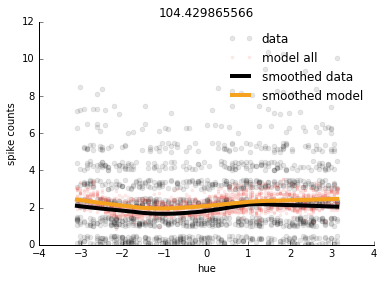

spikes.6400
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0712626602227
...runnning cv-fold 2 of 2
pseudo_R2:  0.0245553545751
pseudo_R2_cv: 0.047909 (+/- 0.016514)
------------------------------------------------------------



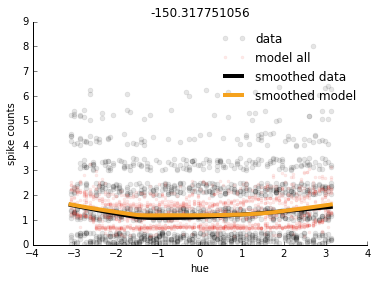

spikes.7300
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.089665496301
...runnning cv-fold 2 of 2
pseudo_R2:  0.0332305718564
pseudo_R2_cv: 0.061448 (+/- 0.019953)
------------------------------------------------------------



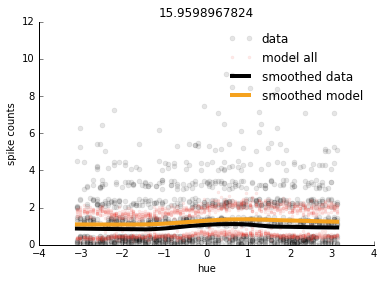

spikes.7500
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.332820510902
...runnning cv-fold 2 of 2
pseudo_R2:  0.168513266815
pseudo_R2_cv: 0.250667 (+/- 0.058091)
------------------------------------------------------------



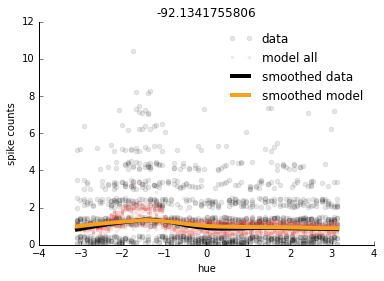

spikes.7800
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.158894055366
...runnning cv-fold 2 of 2
pseudo_R2:  0.0359911969565
pseudo_R2_cv: 0.097443 (+/- 0.043453)
------------------------------------------------------------



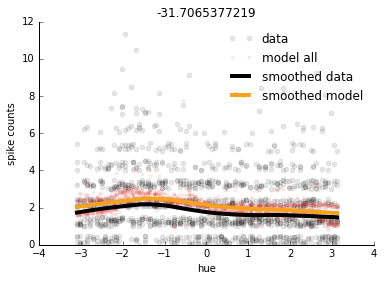

spikes.8000
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.030883070341
...runnning cv-fold 2 of 2
pseudo_R2:  0.0150813426712
pseudo_R2_cv: 0.022982 (+/- 0.005587)
------------------------------------------------------------



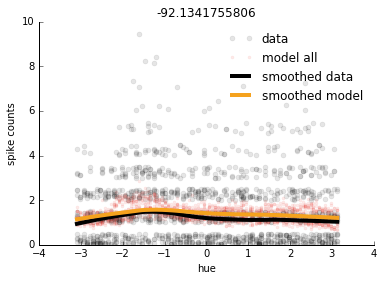

spikes.8100
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0953233615061
...runnning cv-fold 2 of 2
pseudo_R2:  0.0877835528451
pseudo_R2_cv: 0.091553 (+/- 0.002666)
------------------------------------------------------------



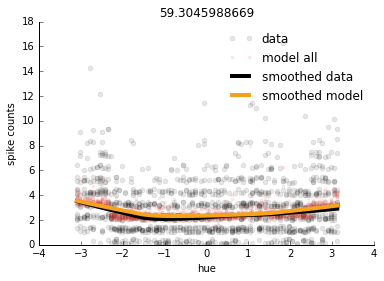

spikes.8300
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.10230434814
...runnning cv-fold 2 of 2
pseudo_R2:  0.0589226393548
pseudo_R2_cv: 0.080613 (+/- 0.015338)
------------------------------------------------------------



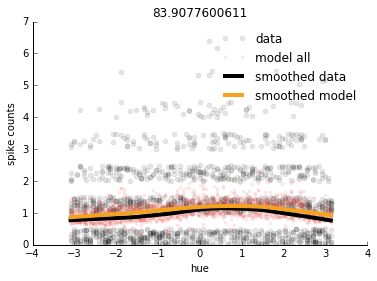

spikes.8300
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  0.00567390929226
...runnning cv-fold 2 of 3
pseudo_R2:  -0.0542948608815
...runnning cv-fold 3 of 3
pseudo_R2:  -0.0950366133273
pseudo_R2_cv: -0.047886 (+/- 0.023881)
------------------------------------------------------------



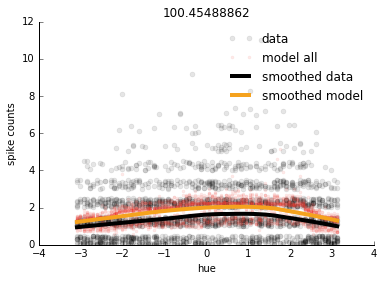

spikes.8400
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.034672157217
...runnning cv-fold 2 of 2
pseudo_R2:  0.0289166007501
pseudo_R2_cv: 0.031794 (+/- 0.002035)
------------------------------------------------------------



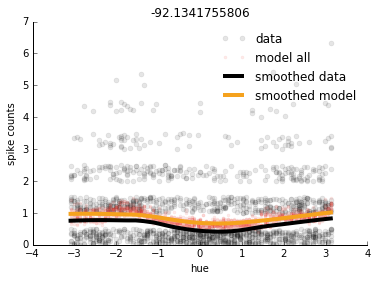

spikes.8400
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  0.1210940502
...runnning cv-fold 2 of 3
pseudo_R2:  -0.0101739011521
...runnning cv-fold 3 of 3
pseudo_R2:  -0.0462690034924
pseudo_R2_cv: 0.021550 (+/- 0.041520)
------------------------------------------------------------



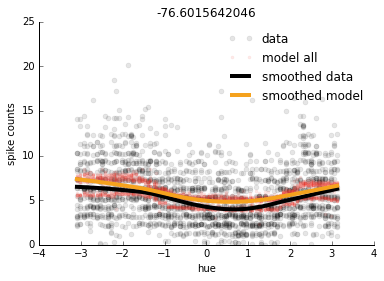

spikes.8600
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0172462565663
...runnning cv-fold 2 of 2
pseudo_R2:  0.0504218423274
pseudo_R2_cv: 0.033834 (+/- 0.011729)
------------------------------------------------------------



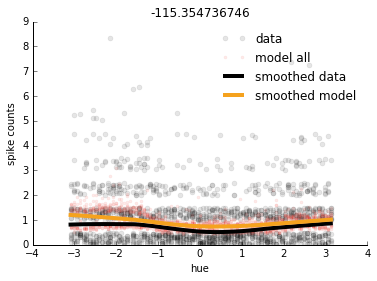

spikes.8700
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0307960772813
...runnning cv-fold 2 of 2
pseudo_R2:  0.0303660306656
pseudo_R2_cv: 0.030581 (+/- 0.000152)
------------------------------------------------------------



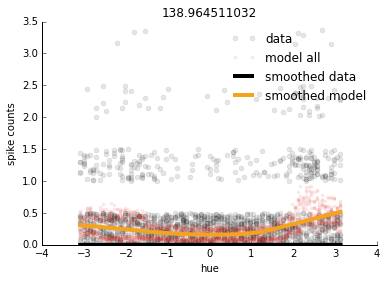

spikes.8700
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 5
pseudo_R2:  -0.0157335057065
...runnning cv-fold 2 of 5
pseudo_R2:  0.113391130264
...runnning cv-fold 3 of 5
pseudo_R2:  0.13200902988
...runnning cv-fold 4 of 5
pseudo_R2:  0.11016739303
...runnning cv-fold 5 of 5
pseudo_R2:  -0.0311857370382
pseudo_R2_cv: 0.061730 (+/- 0.031361)
------------------------------------------------------------



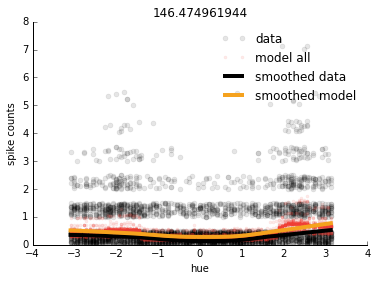

spikes.8800
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.138075313907
...runnning cv-fold 2 of 2
pseudo_R2:  0.0627406613551
pseudo_R2_cv: 0.100408 (+/- 0.026635)
------------------------------------------------------------



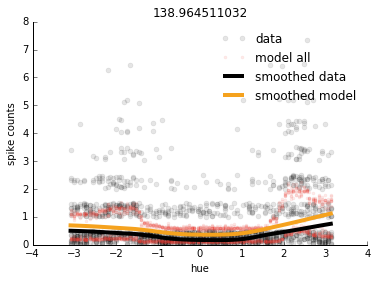

spikes.9000
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  0.177836146047
...runnning cv-fold 2 of 3
pseudo_R2:  0.0870651938621
...runnning cv-fold 3 of 3
pseudo_R2:  0.113296498072
pseudo_R2_cv: 0.126066 (+/- 0.022021)
------------------------------------------------------------



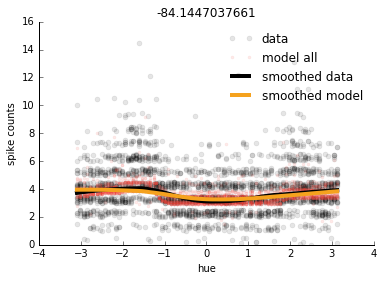

spikes.9000
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0196101272143
...runnning cv-fold 2 of 2
pseudo_R2:  0.077015541435
pseudo_R2_cv: 0.048313 (+/- 0.020296)
------------------------------------------------------------



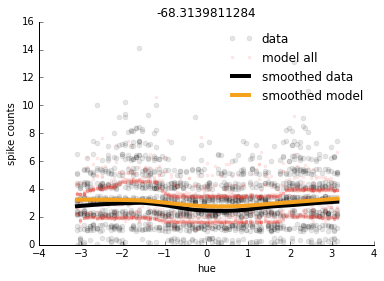

spikes.9000
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  0.136128570151
...runnning cv-fold 2 of 3
pseudo_R2:  0.219427447243
...runnning cv-fold 3 of 3
pseudo_R2:  0.132356935034
pseudo_R2_cv: 0.162638 (+/- 0.023201)
------------------------------------------------------------



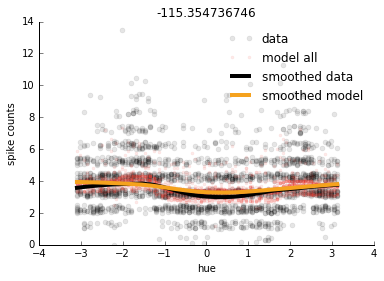

spikes.9100
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.00898553742424
...runnning cv-fold 2 of 2
pseudo_R2:  0.0111884519574
pseudo_R2_cv: 0.010087 (+/- 0.000779)
------------------------------------------------------------



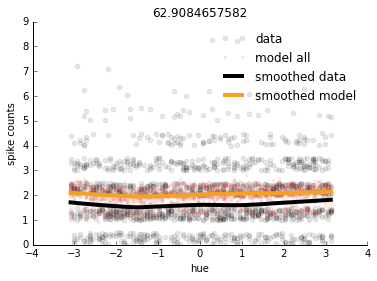

spikes.9200
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0370198373832
...runnning cv-fold 2 of 2
pseudo_R2:  0.0971697239129
pseudo_R2_cv: 0.067095 (+/- 0.021266)
------------------------------------------------------------



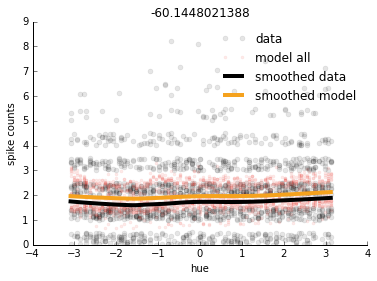

spikes.9200
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  0.033616622114
...runnning cv-fold 2 of 3
pseudo_R2:  0.0630773744799
...runnning cv-fold 3 of 3
pseudo_R2:  0.0312449594144
pseudo_R2_cv: 0.042646 (+/- 0.008360)
------------------------------------------------------------



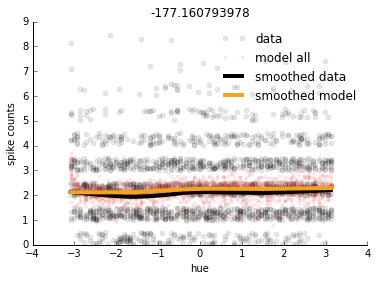

spikes.9200
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.00766938220505
...runnning cv-fold 2 of 2
pseudo_R2:  0.00832951914551
pseudo_R2_cv: 0.007999 (+/- 0.000233)
------------------------------------------------------------



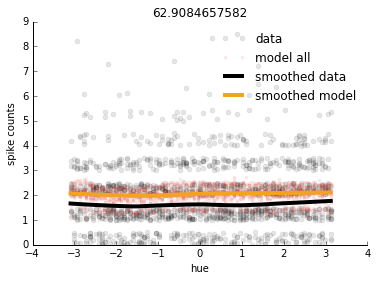

spikes.9600
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0331066555554
...runnning cv-fold 2 of 2
pseudo_R2:  0.00933875901099
pseudo_R2_cv: 0.021223 (+/- 0.008403)
------------------------------------------------------------



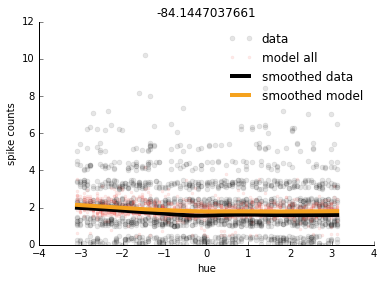

spikes.9600
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.124125087606
...runnning cv-fold 2 of 2
pseudo_R2:  0.0104640339024
pseudo_R2_cv: 0.067295 (+/- 0.040185)
------------------------------------------------------------



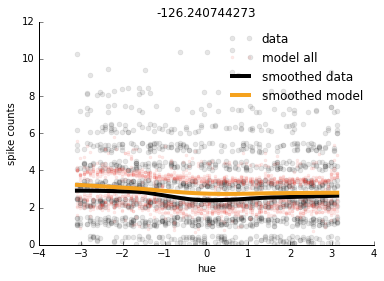

In [17]:
df_fits_art_all = pd.DataFrame(columns=['art_model'])

Models_art = dict()
#Models_art['hue'] = dict()
#Models_art['hue']['covariates'] = ['predictors.hue']

Models_art['all'] = dict()
Models_art['all']['covariates'] = ['predictors.hue', 
                                   'predictors.col', 
                                   'predictors.row', 
                                   'predictors.hue_prev', 
                                   'predictors.stim_dur', 
                                   'predictors.off_to_onset_times']

for neuron_id, neuron_name in enumerate(df_neurons['name']):
    
    print neuron_name
    
    # Extract session numbers
    art_sessions_of_interest = df_neurons.loc[neuron_id]['art_sessions']
    
    # Grab relevant data
    df_sessions_of_interest = df.loc[df['session.number'].isin(art_sessions_of_interest)]
    
    # Labels and number of folds for stratified CV
    labels = df_sessions_of_interest['session.number']
    n_cv = np.size(np.unique(art_sessions_of_interest))
    
    # Get spike counts
    Y = df_sessions_of_interest[neuron_name].values
    
    # Loop through models
    for model_number, model in enumerate(Models_art):
        print 'running model %d of %d: %s' % (model_number+1, len(Models_art), model)
        
        # Get covariates
        X = df_sessions_of_interest[Models_art[model]['covariates']].values        
        
        # Fit models
        Yt_hat, pseudo_R2 = V4.fit_cv(X, Y,
                                      stratify_by_labels=labels,
                                      n_cv=n_cv,
                                      algorithm='XGB_poisson',
                                      verbose=2)
        
        Models_art[model]['Yt_hat'], Models_art[model]['pseudo_R2'] = Yt_hat, pseudo_R2    
        print ''

        x_data = df_sessions_of_interest['predictors.hue'].values
        y_data = Y
        xlabel = 'hue'
        V4.plot_xy(x_data=x_data, y_data=y_data,
                   y_model=Models_art[model]['Yt_hat'],
                   lowess_frac=0.5, xlabel=xlabel, model_name=model, 
                   x_jitter_level=0., y_jitter_level=0.5)
        plt.title((X[np.argmax(Models_art[model]['Yt_hat'])]*180/np.pi)[0])
        #plt.ylim([0,4])
        plt.show()
        temp = dict()
        temp['hue'] = df_sessions_of_interest['predictors.hue'].values
        temp['spike_counts'] = Y
        temp['predicted_spike_counts'] = Yt_hat   
        temp['pseudo_R2'] = pseudo_R2
        
    df_fits_art_all.loc[neuron_id] = [temp]

### Visualize example neuron

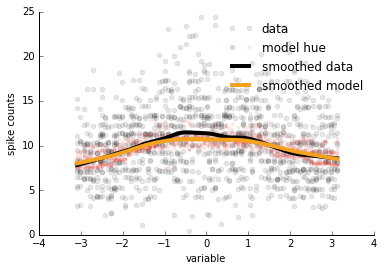

In [7]:
neuron_id = 31
V4.plot_xy(x_data=df_all.loc[neuron_id]['art_model']['hue'], 
           y_data=df_all.loc[neuron_id]['art_model']['spike_counts'], 
           y_model=df_all.loc[neuron_id]['art_model']['predicted_spike_counts'])

## B. Natural and synthetic tuning curves [hue histograms and VGG16]

### Read session files and get predictors and spike counts into a useful data frame

In [7]:
nat_sessions =dict()
for i, f in enumerate(np.sort(np.unique(data_M3['Natural']))):
    nat_sessions[i] = f
nat_sessions

{0: u'Ro150125_s83a_FreeViewPic_0004',
 1: u'Ro150125_s83a_FreeViewPic_0005',
 2: u'Ro150127_s84a_FreeViewPic_0001',
 3: u'Ro150128_s85a_FreeViewPic_0001',
 4: u'Ro150129_s86a_FreeViewPic_0001',
 5: u'Ro150129_s86a_FreeViewPic_0005',
 6: u'Ro150210_s87a_FreeViewPic_manyimage_0004',
 7: u'Ro150211_s88a_FreeViewPic_manyimages_0004',
 8: u'Ro150211_s88a_FreeViewPic_manyimages_0005',
 9: u'Ro150212_289a_FreeViewPic_manyimages_0004',
 10: u'Ro150213_s90a_FreeViewPic_0004',
 11: u'Ro150216_s91a_FreeViewPic_0004',
 12: u'Ro150216_s91a_FreeViewPic_0005',
 13: u'Ro150217_s92a_FreeViewPic_0004',
 14: u'Ro150217_s92a_FreeViewPic_0005'}

### Concatenate across sessions

In [8]:
dfs = list()
for s in nat_sessions:
    fname = h5path + nat_sessions[s] + '_nev.h5'
    df0 = V4.nat_file_to_df(session_number=s, 
                            session_name=fname,
                            in_screen_radius=200,
                            neurons=None, 
                            window=[50, 300])
    dfs.append(df0)
    print nat_sessions[s], len(df0), "fixations", len(df0.filter(regex="spikes").columns), "neurons"

Ro150125_s83a_FreeViewPic_0004 3243 fixations 53 neurons


KeyboardInterrupt: 

In [ ]:
# Concatenate
nat_df = pd.concat( (dfs))

# Reorder
reordered = list()
reordered.extend(tuple([c for c in nat_df.columns if 'predictors.' in c]))
reordered.extend(tuple([c for c in nat_df.columns if 'im.' in c]))
reordered.extend(tuple([c for c in nat_df.columns if 'filters.' in c]))
reordered.extend(tuple(np.sort([c for c in nat_df.columns if 'spikes.' in c])))
reordered.extend(tuple([c for c in nat_df.columns if 'session.' in c]))
nat_df = nat_df[reordered]
nat_df.reset_index(drop=True, inplace=True)
print len(nat_df.filter(regex='spikes').columns), "neurons across sessions"
nat_df.head()

In [48]:
nat_df.to_pickle('../02-preprocessed_data/merged_nat_data_across_sessions')

### Read in precomputed data frame

In [5]:
nat_df = pd.read_pickle('../02-preprocessed_data/M3/merged_nat_data_across_sessions')

### Extract features

In [46]:
# Setup some conditions according to which trials are rejected
reject_conditions = dict()
reject_conditions['filters.in_screen_radius'] = True 
reject_conditions['filters.badfix'] = False

non_image_features_list = ['predictors.col',
                           'predictors.row',
                           'predictors.trial',
                           'predictors.fixation', 
                           'predictors.out_sac_blink',
                           'predictors.in_sac_dur',
                           'predictors.fix_duration',
                           'predictors.prev_fix_duration',
                           'predictors.drift', 
                           'predictors.out_sac_dur',
                           'predictors.next_fix_duration']

# Compute predictive features for X matrix
nat_features = V4.get_nat_features(df=nat_df,
                                reject_conditions=reject_conditions,
                                stimpath='../V4pydata',
                                radius=200, RF_block=14,
                                n_histogram_bins=16,
                                model_list=['histogram', 'vgg'],
                                non_image_features_list=non_image_features_list)

100%|██████████| 77691/77691 [58:14<00:00, 23.56it/s]


In [53]:
nat_features.to_pickle('../02-preprocessed_data/precomputed_nat_features')

### Fit models to each neuron

In [8]:
nat_features = pd.read_pickle('../02-preprocessed_data/M3/precomputed_nat_features')

In [9]:
from tqdm import tqdm

In [16]:
# Instantiate vgg models
#vgg_model_l8 = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
#                                    weights_file='../02-preprocessed_data/vgg16_weights.h5',
#                                    n_pops=0)
#vgg_model_l7 = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
#                                    weights_file='../02-preprocessed_data/vgg16_weights.h5',
#                                    n_pops=1)
#vgg_model_l6 = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
#                                    weights_file='../02-preprocessed_data/vgg16_weights.h5',
#                                    n_pops=3)
# vgg_model_l5 = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
#                                    weights_file='../02-preprocessed_data/vgg16_weights_tf_dim_ordering_tf_kernels.h5',
#                                    n_pops=5,verbose=1)

vgg_model_l7 = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
                                    weights_file='../02-preprocessed_data/vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                    n_pops=1)

/opt/anaconda/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py:1206: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_initializer="glorot_uniform", kernel_constraint=None, activity_regularizer=None, trainable=True, padding="valid", strides=[1, 1], filters=64, use_bias=True, name="convolution2d_1", bias_regularizer=None, bias_constraint=None, data_format="channels_first", kernel_regularizer=None, activation="relu", kernel_size=(3, 3))`
  return cls(**config)
/opt/anaconda/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py:1206: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_initializer="glorot_uniform", kernel_constraint=None, activity_regularizer=None, trainable=True, padding="valid", strides=[1, 1], filters=64, use_bias=True, name="convolution2d_2", bias_regularizer=None, bias_constraint=None, data_format="channels_first", kernel_regularizer=None, activation="relu", kernel_size=(3, 3))`
  return cls(**config

In [19]:
vgg_model_l7= V4.vgg_transfer_ari(n_pops=1,
                      verbose=1)

0 (3, 3, 3, 64)
1 (64,)
2 (3, 3, 64, 64)
3 (64,)
4 (3, 3, 64, 128)
5 (128,)
6 (3, 3, 128, 128)
7 (128,)
8 (3, 3, 128, 256)
9 (256,)
10 (3, 3, 256, 256)
11 (256,)
12 (3, 3, 256, 256)
13 (256,)
14 (3, 3, 256, 512)
15 (512,)
16 (3, 3, 512, 512)
17 (512,)
18 (3, 3, 512, 512)
19 (512,)
20 (3, 3, 512, 512)
21 (512,)
22 (3, 3, 512, 512)
23 (512,)
24 (3, 3, 512, 512)
25 (512,)
26 (25088, 4096)
27 (4096,)
28 (4096, 4096)
29 (4096,)


In [20]:
imname = '/stimuli/M3/Hues/img%03d.jpg' % 2
filename = '../V4pydata' + imname
I = cv2.imread(filename)
I_for_vgg = V4.prepare_image_for_vgg(I)
np.squeeze(vgg_model_l7.predict(I_for_vgg))
I_for_vgg.shape

ValueError: Error when checking : expected input_2 to have shape (None, 224, 224, 3) but got array with shape (1, 3, 224, 224)

In [14]:
#from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

#model = VGG16(weights='imagenet', include_top=True)

imname = '/stimuli/M3/Hues/img%03d.jpg' % 9
filename = '../V4pydata' + imname
img_path = filename
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x.shape
#features = model.predict(x)

(1, 224, 224, 3)

In [17]:
np.squeeze(vgg_model_l7.predict(x))


ValueError: Error when checking : expected zeropadding2d_1_input to have shape (None, 3, 224, 224) but got array with shape (1, 224, 224, 3)

In [16]:
n_bins = 16

df_fits_nat_all = pd.DataFrame(columns=['histogram_model'])
#df_fits_vggl8_all = pd.DataFrame(columns=['vggl8_model'])
#df_fits_vggl7_all = pd.DataFrame(columns=['vggl7_model'])
#df_fits_vggl6_all = pd.DataFrame(columns=['vggl6_model'])
#df_fits_vggl5_all = pd.DataFrame(columns=['vggl5_model'])


# Compute feed forward features for plain hue image
Xplain_vgg = list()
stimpath = '../V4pydata'
for stim_id in tqdm(range(360)):
    imname = '/stimuli/M3/Hues/img%03d.jpg' % stim_id
    filename = stimpath + imname
    I = cv2.imread(filename)
    I_for_vgg = V4.prepare_image_for_vgg(I)
    Xplain_vgg.append(np.squeeze(vgg_model_l7.predict(I_for_vgg)))
Xplain_vgg = np.array(Xplain_vgg)

# Define histograms of plain hue stimuli
plain_hue = np.linspace(-np.pi, np.pi, 360)
Xplain_histogram = V4.onehothue(plain_hue, n_bins=n_bins)

# Loop through df_neurons
for neuron_id, neuron_name in enumerate(df_neurons['name']):
    
    print neuron_name
    
    # Extract session numbers
    nat_sessions_of_interest = df_neurons.loc[neuron_id]['nat_sessions']
    
    # Grab relevant data
    nat_df_sessions_of_interest = nat_df.loc[nat_df['session.number'].isin(nat_sessions_of_interest) & \
                                             nat_df.index.isin(nat_features['accepted_indices'])]
    
    # Labels and number of folds for stratified CV
    labels = nat_df_sessions_of_interest['session.number']
    n_cv = np.size(np.unique(nat_sessions_of_interest))
    labels = [] if n_cv == 1 else labels
    n_cv = 10 if n_cv == 1 else n_cv
        
    # Get spike counts
    Y = nat_df_sessions_of_interest[neuron_name].values
    
    #-----------------
    # Get covariates
    #-----------------
    # Select a df of interest
    indices_of_interest = np.array(nat_df_sessions_of_interest.index)
    nat_features_of_interest = \
        nat_features.loc[nat_features['accepted_indices'].isin(indices_of_interest)]
    
    # Convert everything to array
    image_feature = 'hue.histogram'
    n_samples = len(nat_features_of_interest)
    
    # Image features
    n_features = len(nat_features_of_interest['image_features'][nat_features_of_interest.index[0]][image_feature])
    image_features_array = np.zeros((n_samples, n_features))
    image_features_list = [nat_features_of_interest['image_features'][k][image_feature] \
                           for k in nat_features_of_interest.index]
    for k in range(n_samples):
        image_features_array[k, :] = image_features_list[k]
    
    # Non-image features
    n_features = np.shape(nat_features_of_interest['non_image_features'][nat_features_of_interest.index[0]].values)[0]
    non_image_features_array = np.zeros((n_samples, n_features))
    non_image_features_list = [nat_features_of_interest['non_image_features'][k].values \
                           for k in nat_features_of_interest.index]
    for k in range(n_samples):
        non_image_features_array[k, :] = non_image_features_list[k]

    # Concatenate
    X = np.concatenate((image_features_array, 
                           non_image_features_array), 
                          axis=1)

    #X = nat_features_to_array(nat_features_of_interest, 'vgg.l7')

    #-------------
    # Fit models
    #-------------
    # Cross-validated predictions and scores
    Yt_hat, pseudo_R2 = V4.fit_cv(X, Y,
                                  stratify_by_labels=labels,
                                  n_cv=n_cv,
                                  algorithm='keras_GLM',
                                  verbose=2)
    
    # Predict on plain hue stimuli
    model = V4.fit(X, Y, algorithm='keras_GLM')
    #save model
    V4.save_model(model,name = neuron_name + '_fitted_nat', path = '../02-preprocessed_data/M3/fit_models')
    
    Xplain_augment = np.concatenate((Xplain_histogram, 
                                     X[np.random.randint(0, X.shape[0], Xplain_histogram.shape[0]), n_bins:]), 
                                    axis=1)
    #Xplain_augment = np.concatenate((Xplain_vgg, 
    #                                 X[np.random.randint(0, X.shape[0], Xplain_vgg.shape[0]), Xplain_vgg.shape[1]:]), 
    #                                axis=1)
    Yplain_hat = model.predict(xgb.DMatrix(Xplain_augment))
    
    print ''

    # Visualize fits
    x_data = np.array([nat_features_of_interest['image_features'][k]['hue.mean'] \
                      for k in nat_features_of_interest.index])
    y_data = Y
    xlabel = 'hue'
    V4.plot_xy(x_data=x_data, y_data=y_data,
               y_model=Yt_hat,
               lowess_frac=0.5, xlabel=xlabel, model_name='', 
               x_jitter_level=0., y_jitter_level=0.5)
    plt.title((X[np.argmax(Yt_hat)] * 180/np.pi)[0])
    #plt.ylim([0,4])
    plt.show()
    
    # Accumulate everything for later
    temp = dict()
    temp['hue'] = x_data
    temp['spike_counts'] = Y
    temp['predicted_spike_counts'] = Yt_hat
    temp['pseudo_R2'] = pseudo_R2
    temp['plain_hue'] = plain_hue
    temp['plain_predicted_spike_counts'] = Yplain_hat
    df_fits_nat_all.loc[neuron_id] = [temp]
    

  0%|          | 0/360 [00:00<?, ?it/s]


ValueError: GpuElemwise. Input dimension mis-match. Input 2 (indices start at 0) has shape[1] == 64, but the output's size on that axis is 3.
Apply node that caused the error: GpuElemwise{Composite{(i0 * ((i1 + i2) + Abs((i1 + i2))))}}[(0, 1)](CudaNdarrayConstant{[[[[ 0.5]]]]}, GpuDnnConv{algo='small', inplace=True}.0, GpuDimShuffle{x,0,x,x}.0)
Toposort index: 280
Inputs types: [CudaNdarrayType(float32, (True, True, True, True)), CudaNdarrayType(float32, 4D), CudaNdarrayType(float32, (True, False, True, True))]
Inputs shapes: [(1, 1, 1, 1), (1, 3, 224, 163), (1, 64, 1, 1)]
Inputs strides: [(0, 0, 0, 0), (0, 36512, 163, 1), (0, 1, 0, 0)]
Inputs values: [CudaNdarray([[[[ 0.5]]]]), 'not shown', 'not shown']
Outputs clients: [[GpuIncSubtensor{InplaceSet;::, ::, int64:int64:, int64:int64:}(GpuAlloc{memset_0=True}.0, GpuElemwise{Composite{(i0 * ((i1 + i2) + Abs((i1 + i2))))}}[(0, 1)].0, Constant{1}, Constant{225}, Constant{1}, Constant{225})]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

### Accumulate model predictions in a data frame

In [23]:
df_fits_all = df_neurons.merge(df_fits_art_all, left_index=True, right_index=True)
df_fits_all = df_fits_all.merge(df_fits_nat_all, left_index=True, right_index=True)
df_fits_all = df_fits_all.merge(df_fits_vggl7_all, left_index=True, right_index=True)
df_fits_all.head()

name  art_sessions  \
0  spikes.0101        [2, 3]   
1  spikes.0301        [8, 9]   
2  spikes.0500     [3, 4, 5]   
3  spikes.0500     [4, 5, 6]   
4  spikes.0600  [2, 3, 4, 5]   

                                       art_filenames nat_sessions  \
0  [Ro150127_s84a_huecircle_0003, Ro150128_s85a_h...          [4]   
1  [Ro150211_s88a_huecircle_0003, Ro150212_289a_h...     [11, 12]   
2  [Ro150128_s85a_huecircle_0003, Ro150129_s86a_h...       [5, 6]   
3  [Ro150129_s86a_huecircle_0003, Ro150129_s86a_h...    [6, 7, 8]   
4  [Ro150127_s84a_huecircle_0003, Ro150128_s85a_h...    [4, 5, 6]   

                                       nat_filenames  \
0                   [Ro150129_s86a_FreeViewPic_0001]   
1  [Ro150216_s91a_FreeViewPic_0004, Ro150216_s91a...   
2  [Ro150129_s86a_FreeViewPic_0005, Ro150210_s87a...   
3  [Ro150210_s87a_FreeViewPic_manyimage_0004, Ro1...   
4  [Ro150129_s86a_FreeViewPic_0001, Ro150129_s86a...   

                                           art_model  \
0  {u'pseudo_R2': [0.203104405728, 0.075755813703...   
1  {u'pseudo_R2': [0.687377793089, 0.101933213735...   
2  {u'pseudo_R2': [-0.436355444104, -0.2849994289...   
3  {u'pseudo_R2': [-0.122742425057, 0.20941441713...   
4  {u'pseudo_R2': [-0.242452582303, -0.1639748774...   

                                     histogram_model  \
0  {u'hue': [1.49274933338, 1.27337944508, 1.5420...   
1  {u'hue': [-2.35624170303, -1.21477484703, -1.6...   
2  {u'hue': [-0.89925122261, -0.840216875076, -0....   
3  {u'hue': [2.06351828575, 2.44149160385, 2.5039...   
4  {u'hue': [1.49274933338, 1.27337944508, 1.5420...   

                                         vggl7_model  
0  {u'hue': [1.49274933338, 1.27337944508, 1.5420...  
1  {u'hue': [-2.35624170303, -1.21477484703, -1.6...  
2  {u'hue': [-0.89925122261, -0.840216875076, -0....  
3  {u'hue': [2.06351828575, 2.44149160385, 2.5039...  
4  {u'hue': [1.49274933338, 1.27337944508, 1.5420...

### Save everything

In [24]:
df_fits_all.to_pickle('../02-preprocessed_data/fits_all')

## C. Compare tuning curves

In [7]:
df_fits_all = pd.read_pickle('../02-preprocessed_data/fits_all')

### Visualize single neuron tuning curves and pseudo-$R^2$s

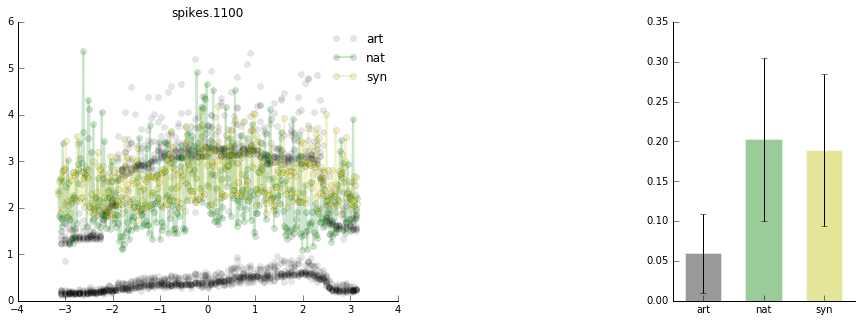

(art, nat): 0.086516
(art, syn): 0.230090
(nat, syn): 0.032360


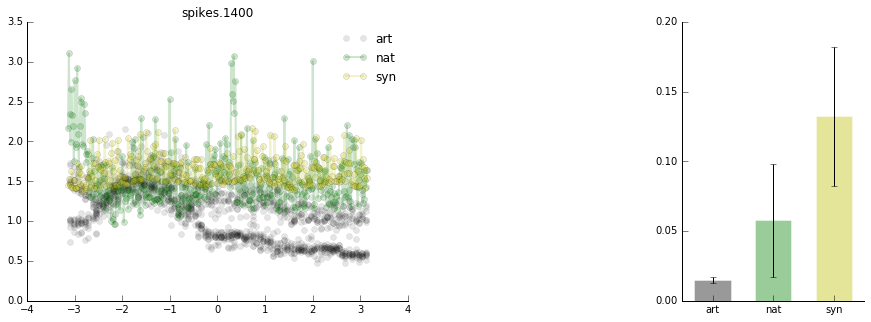

(art, nat): -0.071537
(art, syn): 0.088667
(nat, syn): -0.123264


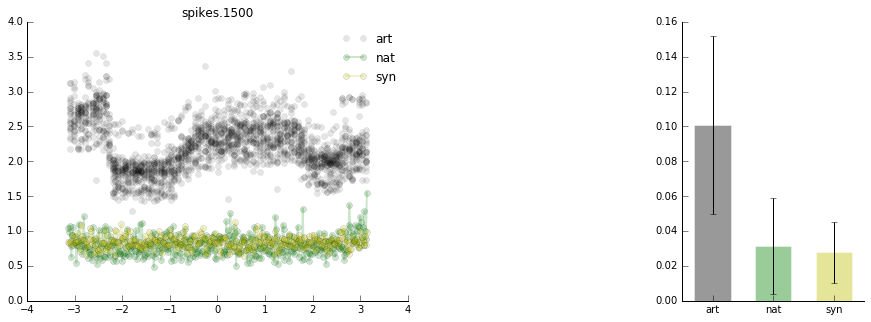

(art, nat): 0.113335
(art, syn): -0.040270
(nat, syn): -0.021506


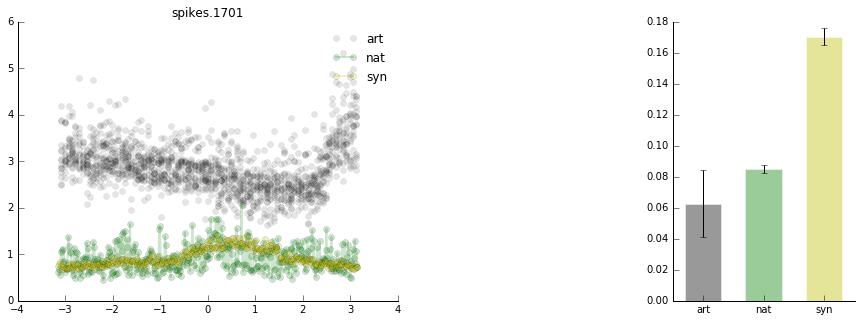

(art, nat): -0.131808
(art, syn): -0.662809
(nat, syn): 0.219987


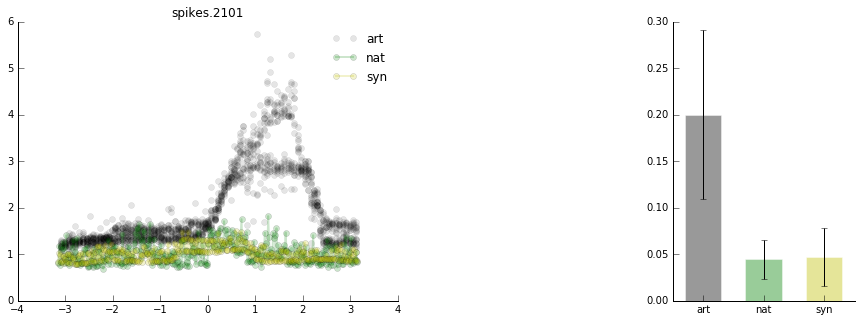

(art, nat): 0.191422
(art, syn): 0.183434
(nat, syn): 0.164637


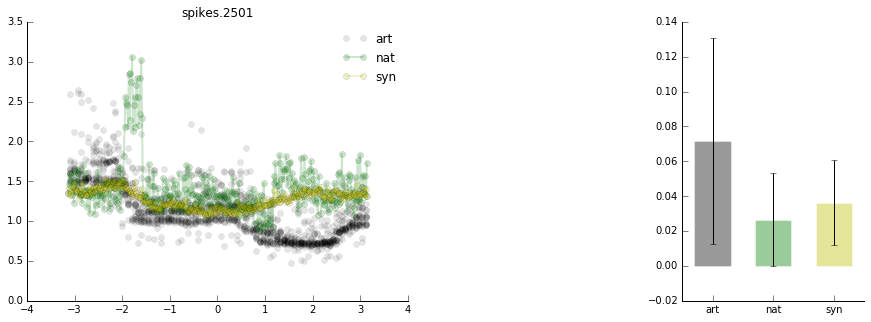

(art, nat): 0.169676
(art, syn): 0.295572
(nat, syn): 0.292136


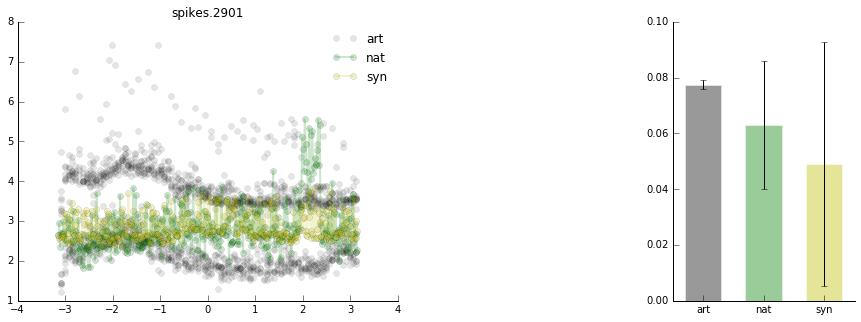

(art, nat): -0.243010
(art, syn): -0.175700
(nat, syn): 0.074869


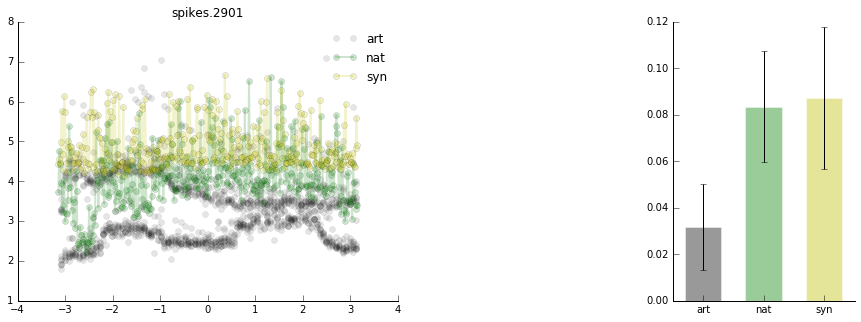

(art, nat): 0.051107
(art, syn): 0.029096
(nat, syn): 0.007422


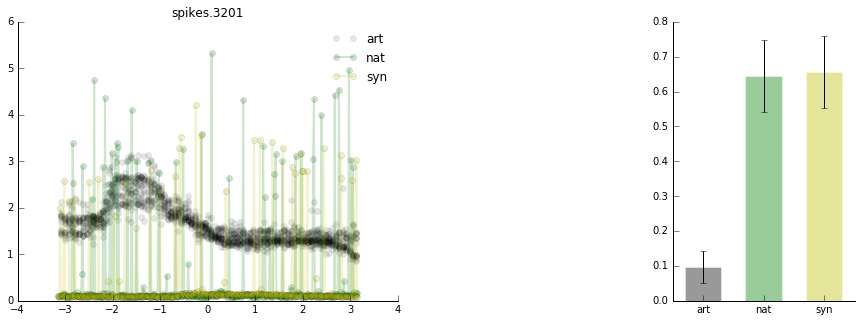

(art, nat): 0.039193
(art, syn): -0.071018
(nat, syn): -0.099121


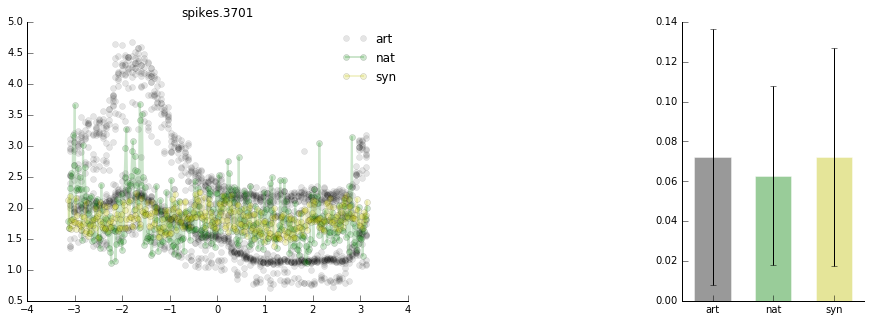

(art, nat): 0.156675
(art, syn): 0.117537
(nat, syn): 0.020749


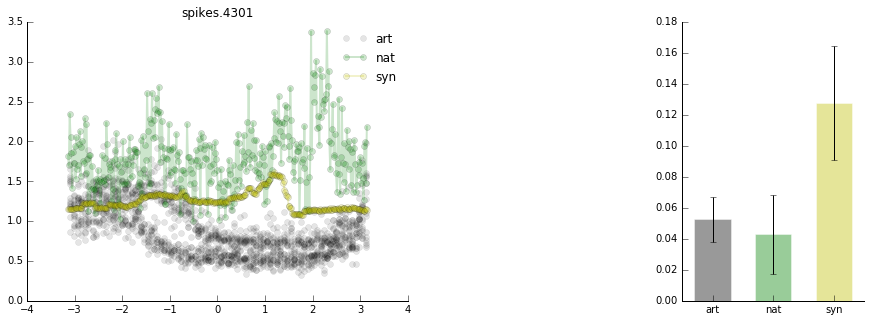

(art, nat): -0.178568
(art, syn): -0.307851
(nat, syn): 0.029052


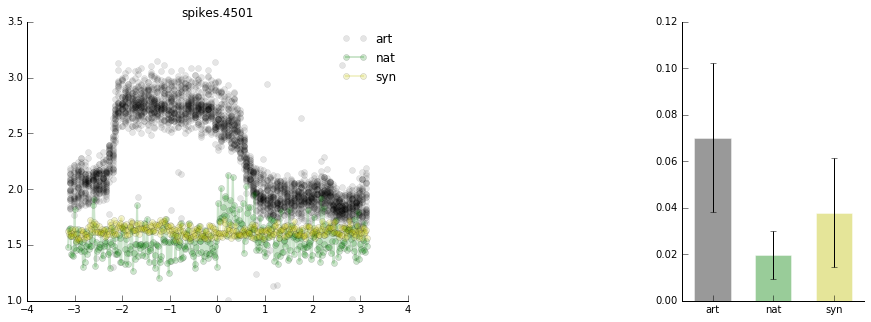

(art, nat): -0.098377
(art, syn): 0.120966
(nat, syn): 0.017729


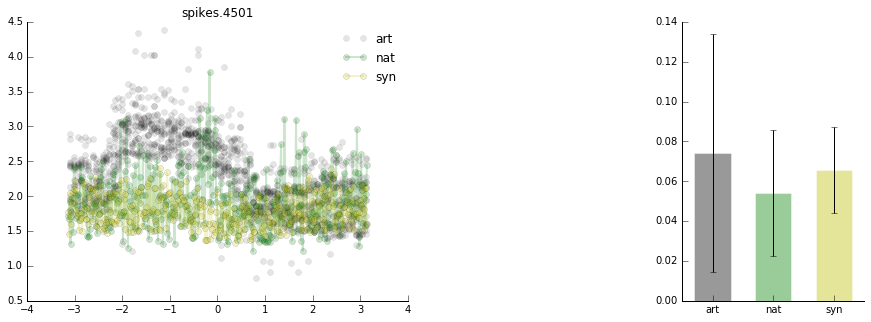

(art, nat): 0.089951
(art, syn): 0.039726
(nat, syn): 0.024856


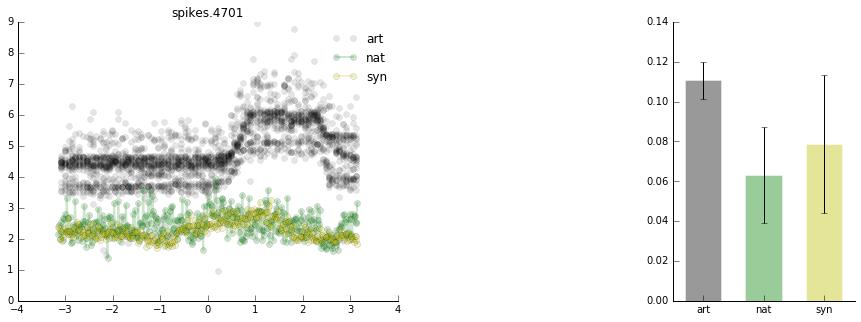

(art, nat): -0.014699
(art, syn): 0.383961
(nat, syn): 0.164695


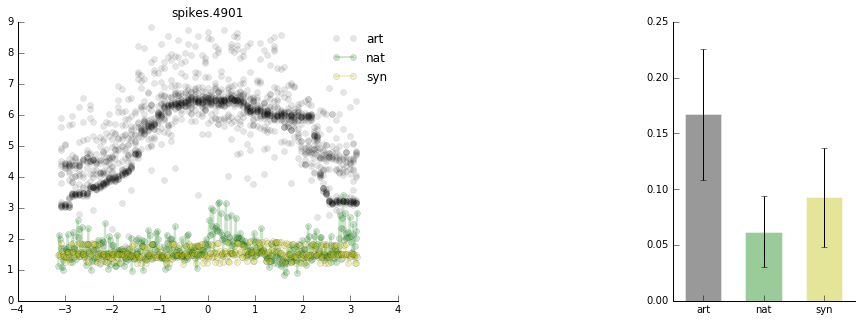

(art, nat): 0.051208
(art, syn): 0.082577
(nat, syn): -0.067812


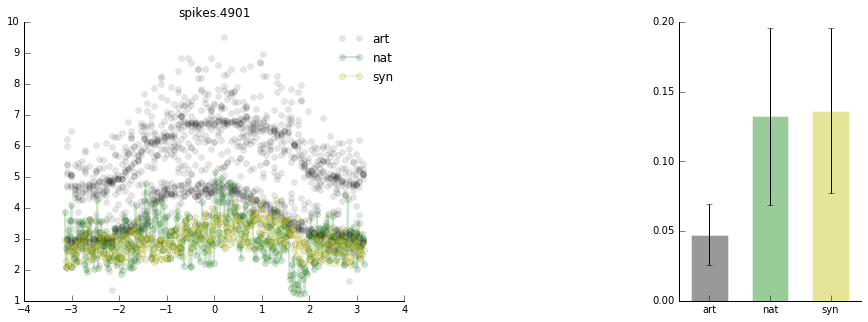

(art, nat): 0.286712
(art, syn): 0.499678
(nat, syn): 0.116025


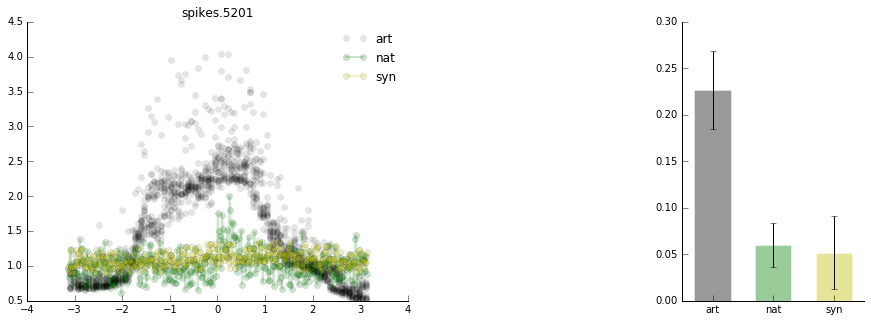

(art, nat): 0.201357
(art, syn): 0.252169
(nat, syn): 0.068615


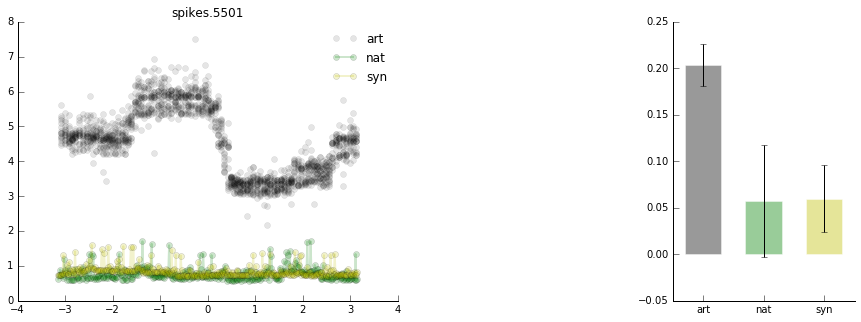

(art, nat): -0.070242
(art, syn): 0.107679
(nat, syn): 0.072220


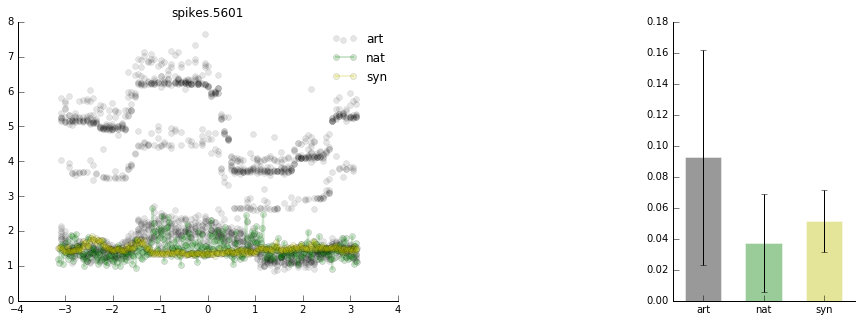

(art, nat): 0.177025
(art, syn): -0.359772
(nat, syn): -0.307567


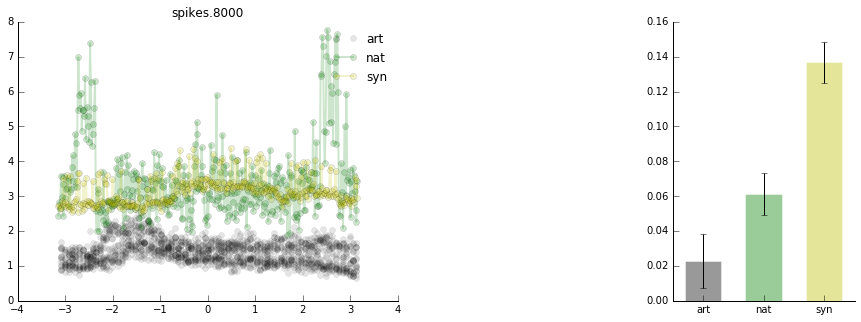

(art, nat): -0.159014
(art, syn): -0.046392
(nat, syn): -0.017049


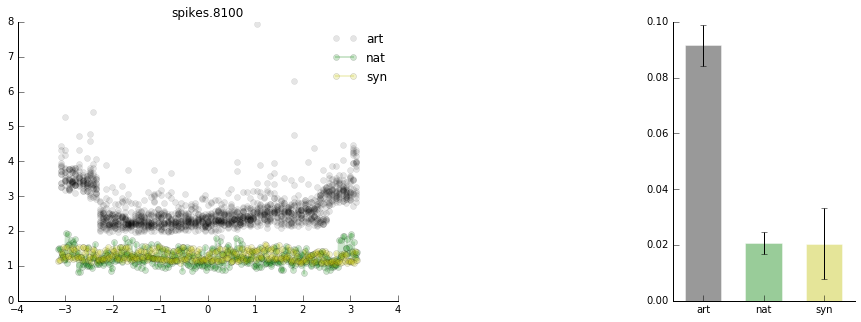

(art, nat): 0.214632
(art, syn): -0.045234
(nat, syn): 0.021364


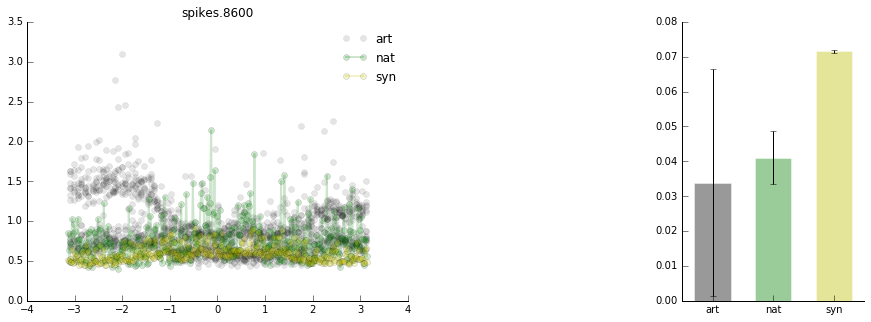

(art, nat): -0.275347
(art, syn): -0.414550
(nat, syn): 0.118279


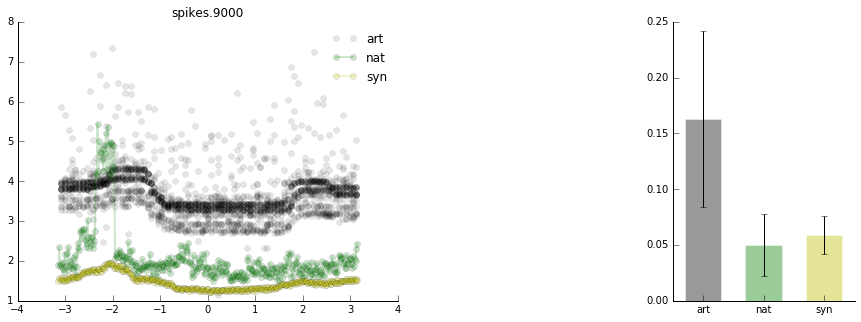

(art, nat): 0.535368
(art, syn): 0.917295
(nat, syn): 0.662506


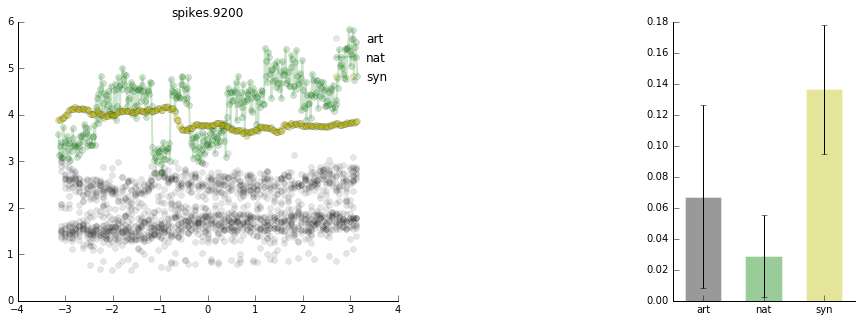

(art, nat): 0.150714
(art, syn): -0.458991
(nat, syn): -0.349122


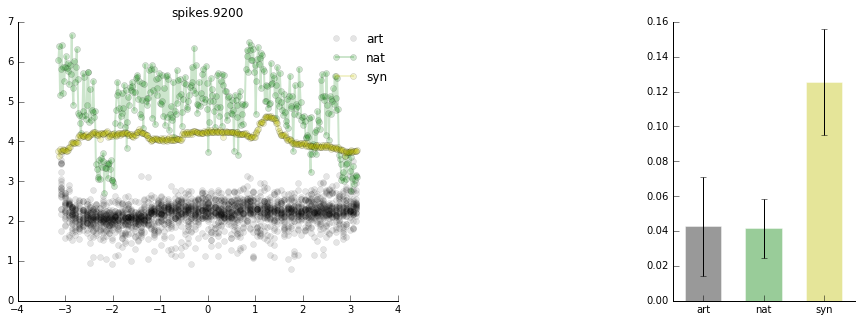

(art, nat): 0.190918
(art, syn): -0.478388
(nat, syn): 0.249810


In [256]:
art_nat_corr = list()
art_syn_corr = list()
nat_syn_corr = list()
        
art_pseudo_R2 = dict()
art_pseudo_R2['mean'] = list()
art_pseudo_R2['std'] = list()

nat_pseudo_R2 = dict()
nat_pseudo_R2['mean'] = list()
nat_pseudo_R2['std'] = list()

syn_pseudo_R2 = dict()
syn_pseudo_R2['mean'] = list()
syn_pseudo_R2['std'] = list()

art_entropy = list()
nat_entropy = list()
syn_entropy = list()

for neuron_id, neuron_name in enumerate(df_neurons['name']):
    if ((np.mean(df_fits_all['vggl7_model'][neuron_id]['pseudo_R2']) - \
         1.96 * np.std(df_fits_all['vggl7_model'][neuron_id]['pseudo_R2']) > 0.) & \
        (np.mean(df_fits_all['art_model'][neuron_id]['pseudo_R2']) - \
         1.96 * np.std(df_fits_all['art_model'][neuron_id]['pseudo_R2']) > 0.)):
        plt.figure(figsize=(15,5))
        
        # Collect all pseudo R2s
        art_pseudo_R2['mean'].append(np.mean(df_fits_all['art_model'][neuron_id]['pseudo_R2']))
        art_pseudo_R2['std'].append(np.std(df_fits_all['art_model'][neuron_id]['pseudo_R2']))
        nat_pseudo_R2['mean'].append(np.mean(df_fits_all['histogram_model'][neuron_id]['pseudo_R2']))
        nat_pseudo_R2['std'].append(np.std(df_fits_all['histogram_model'][neuron_id]['pseudo_R2']))
        syn_pseudo_R2['mean'].append(np.mean(df_fits_all['vggl7_model'][neuron_id]['pseudo_R2']))
        syn_pseudo_R2['std'].append(np.std(df_fits_all['vggl7_model'][neuron_id]['pseudo_R2']))
        
        ax = plt.subplot(121)
        V4.simpleaxis(ax)

        # Fit a polynomial to the art tuning curve
        f_poly = np.poly1d(np.polyfit(df_fits_all['art_model'][neuron_id]['hue'], 
                  df_fits_all['art_model'][neuron_id]['predicted_spike_counts'],
                  5))        
        art_plain_hue = f_poly(df_fits_all['histogram_model'][neuron_id]['plain_hue'])
        #ax.plot(df_fits_all['histogram_model'][neuron_id]['plain_hue'], 
        #        art_plain_hue, 'k-', alpha=0.8)
        
        # Plot art
        ax.plot(df_fits_all['art_model'][neuron_id]['hue'], 
                df_fits_all['art_model'][neuron_id]['predicted_spike_counts'], 'ko', alpha=0.1)

        # Plot nat
        ax.plot(df_fits_all['histogram_model'][neuron_id]['plain_hue'], 
                df_fits_all['histogram_model'][neuron_id]['plain_predicted_spike_counts'], 'go-', alpha=0.2, lw=2)
        
        # Plot syn
        ax.plot(df_fits_all['vggl7_model'][neuron_id]['plain_hue'], 
                df_fits_all['vggl7_model'][neuron_id]['plain_predicted_spike_counts'], 'yo-', alpha=0.2, lw=2)
        ax.legend(['art', 'nat', 'syn'], frameon=False)
        plt.title(neuron_name)
        
        ax= plt.subplot(144)
        V4.simpleaxis(ax)
        ax.bar(left=[1, 2, 3], width=0.6, align='center', alpha=0.4,
               height=[np.mean(df_fits_all['art_model'][neuron_id]['pseudo_R2']),
                       np.mean(df_fits_all['histogram_model'][neuron_id]['pseudo_R2']),
                       np.mean(df_fits_all['vggl7_model'][neuron_id]['pseudo_R2'])],
               yerr=[1.96*np.std(df_fits_all['art_model'][neuron_id]['pseudo_R2']),
                     1.96*np.std(df_fits_all['histogram_model'][neuron_id]['pseudo_R2']),
                     1.96*np.std(df_fits_all['vggl7_model'][neuron_id]['pseudo_R2'])],
               color=['k', 'g', 'y'], ecolor='k', ec='w', tick_label=['art', 'nat', 'syn'])
        
        plt.savefig('../04-figures_cosyne2017/tune_'+re.split('\.', neuron_name)[-1]+'_'+str(neuron_id)+'.pdf', format='pdf')
        plt.show()
        
        # Compute and display correlations
        this_art_nat_corr = np.corrcoef(art_plain_hue, 
                                        df_fits_all['histogram_model'][neuron_id]['plain_predicted_spike_counts'])[0,1]
        this_art_syn_corr = np.corrcoef(art_plain_hue, 
                                        df_fits_all['vggl7_model'][neuron_id]['plain_predicted_spike_counts'])[0,1]
        this_nat_syn_corr = np.corrcoef(df_fits_all['histogram_model'][neuron_id]['plain_predicted_spike_counts'], 
                                        df_fits_all['vggl7_model'][neuron_id]['plain_predicted_spike_counts'])[0,1]

        art_nat_corr.append(this_art_nat_corr)
        art_syn_corr.append(this_art_syn_corr)
        nat_syn_corr.append(this_nat_syn_corr)
        
        print "(art, nat): %f" % this_art_nat_corr
        print "(art, syn): %f" % this_art_syn_corr
        print "(nat, syn): %f" % this_nat_syn_corr
        
        # Compute entropy as a measure of tuning
        tune = art_plain_hue
        #art_entropy.append(-np.sum(tune * np.log(tune)))
        art_entropy.append(tune.max() - tune.min())
        tune = df_fits_all['histogram_model'][neuron_id]['plain_predicted_spike_counts']        
        #nat_entropy.append(-np.sum(tune * np.log(tune)))
        nat_entropy.append(tune.max() - tune.min())
        tune = df_fits_all['vggl7_model'][neuron_id]['plain_predicted_spike_counts']
        syn_entropy.append(tune.max() - tune.min())

art_nat_corr = np.array(art_nat_corr)
art_syn_corr = np.array(art_syn_corr)
nat_syn_corr = np.array(nat_syn_corr)

In [237]:
#import re
re.split('\.', neuron_name)[-1]
#neuron_name

'9600'

### Summary: mean +/ 2 std correlation between tuning curves

In [227]:
print '%6.4f +/- %6.4f' % (np.mean(art_nat_corr), 2 * np.std(art_nat_corr) / np.sqrt(len(art_nat_corr)))
print '%6.4f +/- %6.4f' % (np.mean(art_syn_corr), 2 * np.std(art_syn_corr) / np.sqrt(len(art_syn_corr)))
print '%6.4f +/- %6.4f' % (np.mean(nat_syn_corr), 2 * np.std(nat_syn_corr) / np.sqrt(len(nat_syn_corr)))

0.0585 +/- 0.0722
0.0115 +/- 0.1350
0.0549 +/- 0.0762


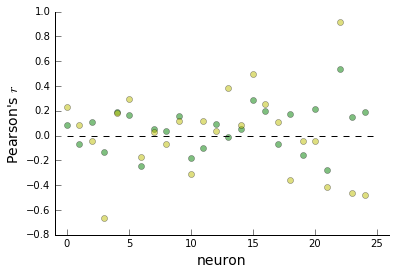

In [255]:
plt.figure()
ax = plt.subplot(111)
V4.simpleaxis(ax)
ax.plot(art_nat_corr, 'go', alpha=0.5)
ax.plot(art_syn_corr, 'yo', alpha=0.5)
ax.plot(np.arange(26), np.zeros(26), 'k--')
plt.xlim([-1, 26])
plt.xlabel('neuron', fontsize=14)
plt.ylabel('Pearson\'s $r$' , fontsize=14)

plt.savefig('population_Pearsons_r.pdf', format='pdf')
plt.show()

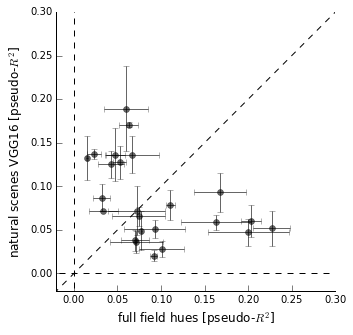

In [254]:
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
V4.simpleaxis(ax)
#ax.errorbar(x=np.array(art_pseudo_R2['mean']), y=np.array(nat_pseudo_R2['mean']), 
#             xerr=np.array(art_pseudo_R2['std']), yerr=np.array(nat_pseudo_R2['std']), fmt='go', alpha=0.3)
ax.errorbar(x=np.array(art_pseudo_R2['mean']), y=np.array(syn_pseudo_R2['mean']), 
             xerr=np.array(art_pseudo_R2['std']), yerr=np.array(syn_pseudo_R2['std']), fmt='ko', alpha=0.6)
ax.plot(np.linspace(-1., 1., 10), np.linspace(-1., 1., 10), 'k--')
ax.plot(np.linspace(-1., 1., 10), np.zeros(10), 'k--')
ax.plot(np.zeros(10), np.linspace(-1., 1., 10), 'k--')
ax.axis([-0.02, 0.3, -0.02, 0.3])
plt.xlabel('full field hues [pseudo-$R^2$]', fontsize=12)
plt.ylabel('natural scenes VGG16 [pseudo-$R^2$]', fontsize=12)

plt.savefig('art_vs_nat_pseudoR2s.pdf', format='pdf')
plt.show()

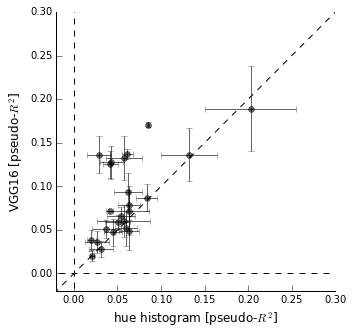

In [253]:
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
V4.simpleaxis(ax)
ax.errorbar(x=np.array(nat_pseudo_R2['mean']), y=np.array(syn_pseudo_R2['mean']), 
             xerr=np.array(nat_pseudo_R2['std']), yerr=np.array(syn_pseudo_R2['std']), fmt='ko', alpha=0.6)
ax.plot(np.linspace(-1., 1., 10), np.linspace(-1., 1., 10), 'k--')
ax.plot(np.linspace(-1., 1., 10), np.zeros(10), 'k--')
ax.plot(np.zeros(10), np.linspace(-1., 1., 10), 'k--')
ax.axis([-0.02, 0.3, -0.02, 0.3])
plt.xlabel('hue histogram [pseudo-$R^2$]', fontsize=12)
plt.ylabel('VGG16 [pseudo-$R^2$]', fontsize=12)

plt.savefig('population_hist_vs_convnet.pdf', format='pdf')
plt.show()

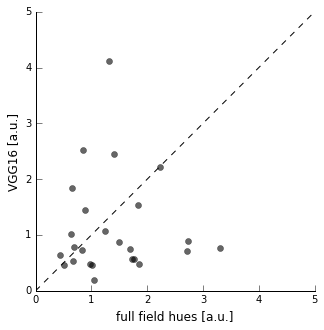

In [252]:
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
V4.simpleaxis(ax)
ax.plot(np.array(art_entropy), np.array(syn_entropy), 'ko', alpha=0.6)
ax.plot(np.linspace(0, 5, 10), np.linspace(0, 5, 10), 'k--')
#ax.plot(np.linspace(0, 5, 10), np.zeros(10), 'k--')
#ax.plot(np.zeros(10), np.linspace(-500, 3500, 10), 'k--')
ax.axis([0, 5, 0, 5])
plt.xlabel('full field hues [a.u.]', fontsize=12)
plt.ylabel('VGG16 [a.u.]', fontsize=12)

#plt.savefig('population_mod_depth.pdf', format='pdf')
plt.show()

In [261]:
syn_pseudo_R2['mean']

[0.18894179203667832,
 0.13227183688969668,
 0.027892551700938333,
 0.1704221810928378,
 0.047177100257969409,
 0.036320425273495216,
 0.049104045984717515,
 0.087057116146126837,
 0.65660170948953311,
 0.071959383168898924,
 0.12752634504658186,
 0.037964713109712972,
 0.0657024976505097,
 0.07852439381793537,
 0.092961103918597937,
 0.1363857837245305,
 0.051800057951889369,
 0.059905332084093356,
 0.051322026279478718,
 0.13671445688163503,
 0.020505832614903963,
 0.071549415887798229,
 0.058764057576401164,
 0.13637367929685046,
 0.12543689618788742]

In [163]:
def hsv_to_rgb(hue=0, sat=255, val=25):
    hsv = np.array([hue, sat, val])
    im = np.zeros((1,1,3))
    im[0, 0, :] = hsv
    im = im.astype(np.uint8)
    rgb = cv2.cvtColor(im, cv2.COLOR_HSV2RGB)
    return rgb[0, 0]

In [72]:
def show_tuning_as_color_strip(tune_art, tune_nat, tune_syn, neuron_name='neuron'):
    n_hues = tune_art.shape[0]
    im = 255. * np.ones((160, n_hues, 3))
        
    mx = np.max([tune_art.max(), tune_nat.max(), tune_syn.max()])
    for hue, art_hue_fr in enumerate(tune_art):    
        norm_fr = art_hue_fr / mx * 255
        for row in range(40):
            im[row, hue, :] = hsv_to_rgb(hue=hue/2, sat=255, val=norm_fr)

    for hue, nat_hue_fr in enumerate(tune_nat):    
        norm_fr = nat_hue_fr / mx * 255
        for row in range(40):
            im[60+row, hue, :] = hsv_to_rgb(hue=hue/2, sat=255, val=norm_fr)
            
    for hue, syn_hue_fr in enumerate(tune_syn):    
        norm_fr = syn_hue_fr / mx * 255
        for row in range(40):
            im[120+row, hue, :] = hsv_to_rgb(hue=hue/2, sat=255, val=norm_fr)
        
    # Plot firing rate
    plt.imshow(im.astype(np.uint8), interpolation='none')
    plt.title(neuron_name)
    plt.axis('off')

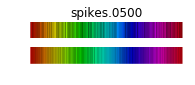

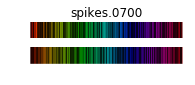

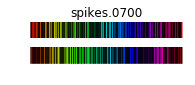

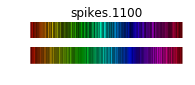

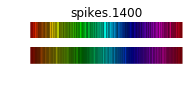

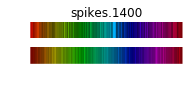

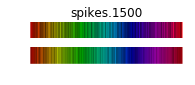

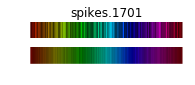

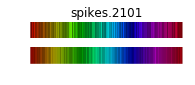

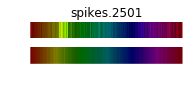

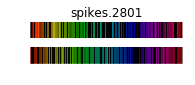

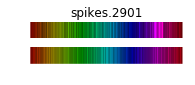

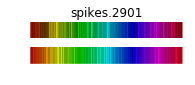

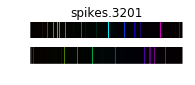

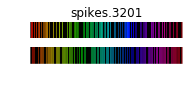

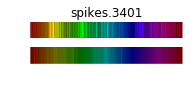

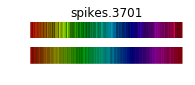

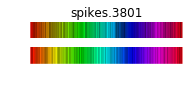

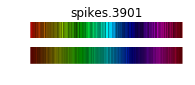

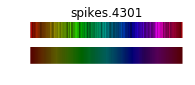

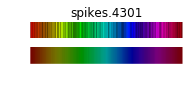

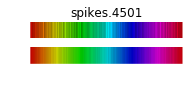

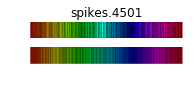

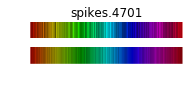

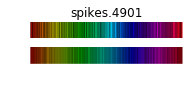

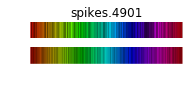

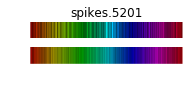

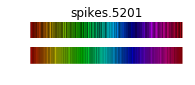

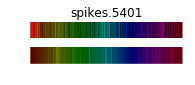

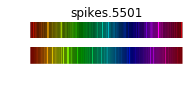

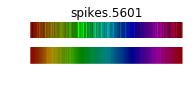

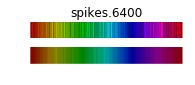

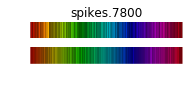

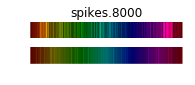

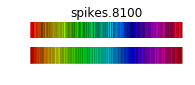

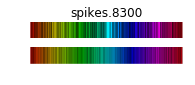

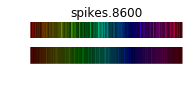

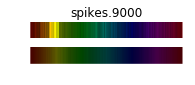

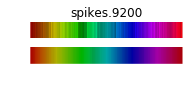

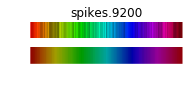

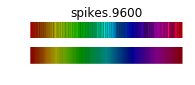

In [63]:
for neuron_id, neuron_name in enumerate(df_neurons['name']):    
    tune_art = df_fits_all['histogram_model'][neuron_id]['plain_predicted_spike_counts']
    tune_nat = df_fits_all['vggl7_model'][neuron_id]['plain_predicted_spike_counts']
    
    if np.mean(df_fits_all['vggl7_model'][neuron_id]['pseudo_R2']) - \
       2. * np.std(df_fits_all['vggl7_model'][neuron_id]['pseudo_R2']) > 0.:
        plt.figure()
        plt.subplot(121)
        show_tuning_as_color_strip(tune_art, tune_nat, neuron_name=neuron_name)

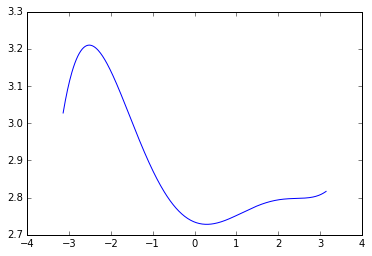

In [95]:
f_tmp = np.poly1d(np.polyfit(df_fits_all['art_model'][neuron_id]['hue'], 
                  df_fits_all['art_model'][neuron_id]['predicted_spike_counts'],
                  5))

# calculate new x's and y's
x_tmp = df_fits_all['histogram_model'][neuron_id]['plain_hue']
y_tmp = f_tmp(x_tmp)
plt.plot(x_tmp, y_tmp)
plt.show()